# Initial setup

In [1]:
import os
import geopandas as gpd
import matplotlib.pyplot as plt
import us
import numpy as np
import pandas as pd

def read_csv(folder_path):
    # Get a list of all files in the folder
    file_list = os.listdir(folder_path)

    # Initialize an empty dictionary to store the dataframes
    dataframes = {}

    # Iterate over each file in the folder
    for file_name in file_list:
        # Check if the file is a CSV file
        if file_name.endswith(".csv"):
            # Remove the file extension to get the key name
            key_name = os.path.splitext(file_name)[0]

            # Construct the full file path
            file_path = os.path.join(folder_path, file_name)

            # Read the CSV file into a dataframe
            df = pd.read_csv(file_path)

            # Store the dataframe in the dictionary using the key name
            dataframes[key_name] = df

    return dataframes


# Loop through each dataframe
def print_dataframe_info(dataframes, print_columns=False):
    for df_name, df in dataframes.items():
        print("Dataframe:", df_name)
        print("Number of rows:", len(df))
        print("Number of columns:", len(df.columns))
        # print(df.info())

        # Check if column names should be printed
        if print_columns:
            # Get column names
            column_names = df.columns

            # Loop through each column
            for column in column_names:
                # Get unique values in the column
                unique_values = df[column].nunique()

                # Print the column name and number of unique values
                print("Column:", column)
                print("Number of unique values:", unique_values)
                print("---")
        #        else:
        #           print("")
        print("\n")
def compare_columns(df1, df2, column_name):
    # Compare columns between two DataFrames
    column_set_1 = set(df1[column_name])
    column_set_2 = set(df2[column_name])

    # Find values in df1 that are not in df2
    values_only_in_df1 = column_set_1 - column_set_2

    # Find values in df2 that are not in df1
    values_only_in_df2 = column_set_2 - column_set_1

    # Print the results
    print("pr:", values_only_in_df1)
    print("cf:", values_only_in_df2)

change juptercodeformater settings:
{
    'formatOnSave' : true
}

In [2]:
dataframes = read_csv("election")
pr = dataframes["primary_results"]
cfd = dataframes["county_facts_dictionary"]
cf = dataframes["county_facts"]

#Add descrtions to county facts column name
for column_name in cf.columns:
    if column_name in cfd["column_name"].values:
        # Find the corresponding description in the name-description DataFrame
        description = cfd.loc[cfd["column_name"] == column_name, "description"].iloc[0]
        # Replace the column name with the description in the original DataFrame
        cf.rename(columns={column_name: description}, inplace=True)
cf['area_name'] = cf['area_name'].str.replace('County', '').str.strip()
pr['county'] = pr['county'].str.replace('County', '').str.strip()

# Analysing datasets to define beset relations

In [181]:
for df in dataframes:
    print(dataframes[df].isnull().any().any())

True
False
True


In [212]:
pr[pr['fips'].isnull()]

Empty DataFrame
Columns: [state, state_abbreviation, county, fips, party, candidate, votes, fraction_votes, fipsadd]
Index: []

In [186]:
from addfips import AddFIPS
af = AddFIPS()

# Add FIPS codes to the DataFrame
for index, row in pr.iterrows():
    state_name = row['state']
    county_name = row['county']
    fips_code = af.get_county_fips(county_name, state=state_name)
    pr.loc[index, 'fipsadd'] = fips_code
pr['fipsadd'] = pr['fipsadd'].astype(float)

In [237]:
pr['fips'] = pr['fips'].fillna(pr['fipsadd'])

In [238]:
pr[pr['candidate'] == 'Bernie Sanders']['votes'].describe()

count      4205.000000
mean       2844.019501
std       12262.797504
min           0.000000
25%         101.000000
50%         450.000000
75%        1550.000000
max      434656.000000
Name: votes, dtype: float64

In [239]:
prf = pd.pivot_table(pr, index=["fips",'state','state_abbreviation','county'], columns="candidate", values="votes", fill_value=0)
prf = prf.reset_index()
prf = prf.drop([' No Preference', ' Uncommitted'], axis = 1)

picking candidates with reasonable number of votes

In [241]:
prf.iloc[:,4:].describe()

candidate   Ben Carson  Bernie Sanders  Carly Fiorina  Chris Christie   
count      4217.000000     4217.000000    4217.000000     4217.000000  \
mean        133.875504     2835.926488       3.602324        5.774959   
std         530.134610    12246.270595      78.551516      150.920573   
min           0.000000        0.000000       0.000000        0.000000   
25%           0.000000       98.000000       0.000000        0.000000   
50%           0.000000      448.000000       0.000000        0.000000   
75%          49.000000     1544.000000       0.000000        0.000000   
max        9945.000000   434656.000000    3612.000000     7144.000000   

candidate   Donald Trump  Hillary Clinton     Jeb Bush    John Kasich   
count        4217.000000      4217.000000  4217.000000    4217.000000  \
mean         3154.503438      3721.235950    22.388191     986.471188   
std          8403.605681     16889.242651   297.752447    3984.254975   
min             0.000000         0.000000     0.000000       0.000000   
25%           123.000000        56.000000     0.000000      22.000000   
50%           795.000000       544.000000     0.000000     123.000000   
75%          2538.000000      1741.000000     0.000000     485.000000   
max        179130.000000    590502.000000  9575.000000  101217.000000   

candidate    Marco Rubio  Martin O'Malley  Mike Huckabee    Rand Paul   
count        4217.000000      4217.000000    4217.000000  4217.000000  \
mean          787.544700         0.178326       0.793218     2.010671   
std          3536.914936         3.140144      10.347424    33.614465   
min             0.000000         0.000000       0.000000     0.000000   
25%             0.000000         0.000000       0.000000     0.000000   
50%            59.000000         0.000000       0.000000     0.000000   
75%           369.000000         0.000000       0.000000     0.000000   
max        111898.000000       152.000000     565.000000  1633.000000   

candidate  Rick Santorum       Ted Cruz  
count        4217.000000    4217.000000  
mean            0.422575    1802.941902  
std             5.635955    5229.629532  
min             0.000000       0.000000  
25%             0.000000      45.000000  
50%             0.000000     339.000000  
75%             0.000000    1437.000000  
max           234.000000  147721.000000

In [190]:
prf = prf.drop(['Ben Carson', 'Carly Fiorina', 'Chris Christie', 'Jeb Bush', '''Martin O'Malley''','Mike Huckabee', 'Rand Paul', 'Rand Paul', 'Rick Santorum', 'Marco Rubio'], axis=1)

In [191]:
from addfips import AddFIPS
af = AddFIPS()

# Add FIPS codes to the DataFrame
for index, row in prf.iterrows():
    state_name = row['state']
    county_name = row['county']
    fips_code = af.get_county_fips(county_name, state=state_name)
    prf.loc[index, 'fipsadd'] = fips_code
prf['fipsadd'] = prf['fipsadd'].astype(float)

In [192]:
prf.describe()

candidate          fips  Bernie Sanders   Donald Trump  Hillary Clinton   
count      4.217000e+03     4217.000000    4217.000000      4217.000000  \
mean       3.100444e+07     2835.926488    3154.503438      3721.235950   
std        4.373710e+07    12246.270595    8403.605681     16889.242651   
min        1.001000e+03        0.000000       0.000000         0.000000   
25%        2.404700e+04       98.000000     123.000000        56.000000   
50%        4.700100e+04      448.000000     795.000000       544.000000   
75%        9.230015e+07     1544.000000    2538.000000      1741.000000   
max        9.560004e+07   434656.000000  179130.000000    590502.000000   

candidate    John Kasich       Ted Cruz       fipsadd  
count        4217.000000    4217.000000   2838.000000  
mean          986.471188    1802.941902  31043.075758  
std          3984.254975    5229.629532  15468.110090  
min             0.000000       0.000000   1001.000000  
25%            22.000000      45.000000  18095.500000  
50%           123.000000     339.000000  31016.000000  
75%           485.000000    1437.000000  46785.000000  
max        101217.000000  147721.000000  56045.000000

comparing fipsadd and fips columns

In [193]:
u = prf['fipsadd'].isin(prf['fips'])
prf9 = prf[~u][prf[~u]['fips'] > 10000000]
print('fipsadd is not null - for fips above 90 m')
print(prf9[~prf9['fipsadd'].isnull()].shape[0])
print('fipsadd is null - for fips above 90 m')
print(prf9[prf9['fipsadd'].isnull()].shape[0])
prfn9 = prf[~u][prf[~u]['fips'] < 10000000]
print('fipsadd is not null - for fips bellow 90 m')
print(prfn9[~prfn9['fipsadd'].isnull()].shape[0])
print('fipsadd is null - for fips bellow 90 m')
print(prfn9[prfn9['fipsadd'].isnull()].shape[0])

fipsadd is not null - for fips above 90 m
39
fipsadd is null - for fips above 90 m
1369
fipsadd is not null - for fips bellow 90 m
2
fipsadd is null - for fips bellow 90 m
10


In [194]:
prf = prf.drop('fipsadd', axis = 1)

In [195]:
u = prf['fips'].isin(cf['fips'])
print('fips that are in prf but not in cf')
prnf = prf[~u]
prnf['fips'].nunique()

fips that are in prf but not in cf


1409

In [196]:
prf9.describe()

candidate          fips  Bernie Sanders  Donald Trump  Hillary Clinton   
count      1.408000e+03     1408.000000   1408.000000      1408.000000  \
mean       9.272937e+07     1047.376420    456.365767      1047.489347   
std        1.323085e+06    10184.708041   2673.281779     12022.696976   
min        9.020010e+07        0.000000      0.000000         0.000000   
25%        9.230014e+07        3.000000      0.000000         1.000000   
50%        9.230052e+07      150.500000     45.000000        28.000000   
75%        9.250034e+07      733.250000    473.500000       499.000000   
max        9.560004e+07   311225.000000  91520.000000    366954.000000   

candidate   John Kasich      Ted Cruz       fipsadd  
count       1408.000000   1408.000000     39.000000  
mean         207.072443    149.041903  30141.615385  
std         1562.981643   1508.866716  15187.278064  
min            0.000000      0.000000   9001.000000  
25%            0.000000      0.000000  23011.000000  
50%           26.000000     13.000000  25011.000000  
75%          184.250000    114.000000  50002.000000  
max        53481.000000  50667.000000  50027.000000

In [197]:
prf.describe()

candidate          fips  Bernie Sanders   Donald Trump  Hillary Clinton   
count      4.217000e+03     4217.000000    4217.000000      4217.000000  \
mean       3.100444e+07     2835.926488    3154.503438      3721.235950   
std        4.373710e+07    12246.270595    8403.605681     16889.242651   
min        1.001000e+03        0.000000       0.000000         0.000000   
25%        2.404700e+04       98.000000     123.000000        56.000000   
50%        4.700100e+04      448.000000     795.000000       544.000000   
75%        9.230015e+07     1544.000000    2538.000000      1741.000000   
max        9.560004e+07   434656.000000  179130.000000    590502.000000   

candidate    John Kasich       Ted Cruz  
count        4217.000000    4217.000000  
mean          986.471188    1802.941902  
std          3984.254975    5229.629532  
min             0.000000       0.000000  
25%            22.000000      45.000000  
50%           123.000000     339.000000  
75%           485.000000    1437.000000  
max        101217.000000  147721.000000

In [198]:
prnf[prnf['Bernie Sanders'] > 100000]

candidate        fips     state state_abbreviation        county   
3017       91700103.0  Illinois                 IL       Chicago  \
3018       91700104.0  Illinois                 IL  Cook Suburbs   

candidate  Bernie Sanders  Donald Trump  Hillary Clinton  John Kasich   
3017               311225         32858           366954        21654  \
3018               212428         91520           249217        53481   

candidate  Ted Cruz  
3017          17737  
3018          50667

In [199]:
cf[cf['state_abbreviation'] == 'IL']['area_name'].unique()

array(['Adams', 'Alexander', 'Bond', 'Boone', 'Brown', 'Bureau',
       'Calhoun', 'Carroll', 'Cass', 'Champaign', 'Christian', 'Clark',
       'Clay', 'Clinton', 'Coles', 'Cook', 'Crawford', 'Cumberland',
       'DeKalb', 'De Witt', 'Douglas', 'DuPage', 'Edgar', 'Edwards',
       'Effingham', 'Fayette', 'Ford', 'Franklin', 'Fulton', 'Gallatin',
       'Greene', 'Grundy', 'Hamilton', 'Hancock', 'Hardin', 'Henderson',
       'Henry', 'Iroquois', 'Jackson', 'Jasper', 'Jefferson', 'Jersey',
       'Jo Daviess', 'Johnson', 'Kane', 'Kankakee', 'Kendall', 'Knox',
       'Lake', 'LaSalle', 'Lawrence', 'Lee', 'Livingston', 'Logan',
       'McDonough', 'McHenry', 'McLean', 'Macon', 'Macoupin', 'Madison',
       'Marion', 'Marshall', 'Mason', 'Massac', 'Menard', 'Mercer',
       'Monroe', 'Montgomery', 'Morgan', 'Moultrie', 'Ogle', 'Peoria',
       'Perry', 'Piatt', 'Pike', 'Pope', 'Pulaski', 'Putnam', 'Randolph',
       'Richland', 'Rock Island', 'St. Clair', 'Saline', 'Sangamon',
       'Schuy

In [206]:
u4 = cf['fips'].isin(prf[prf['fips'] < 1000000]['fips'])
print(cf[~u4]['fips'].nunique())
u5 = prf[prf['fips'] > 10000000]['fips'].isin(cf['fips'])
print(prf[prf['fips'] > 10000000][~u5]['fips'].nunique())

387
1409


counties that do not match between pimary reseuls and county facts there 1023 in primary that are not in county facts

In [201]:
u1 = prf['county'].isin(cf['area_name'])
uc = prf[~u1]['county']
print(uc.nunique(), uc.unique())
u3 = cf['area_name'].isin(prf['county'])
print(cf[~u3]['area_name'].nunique())

1021 ['Saint Francis' 'JoDaviess' 'LaRue' ... 'Crook-Weston'
 'Converse-Niobrara' 'Goshen-Platte']
300


In [205]:
prf[~u1].describe()

candidate          fips  Bernie Sanders  Donald Trump  Hillary Clinton   
count      1.189000e+03     1189.000000   1189.000000      1189.000000  \
mean       8.647867e+07     1399.144659    630.433137      1703.633305   
std        2.326254e+07    11932.455672   3131.703596     15176.649844   
min        5.123000e+03        0.000000      0.000000         0.000000   
25%        9.230007e+07        4.000000      0.000000         2.000000   
50%        9.230046e+07      180.000000     57.000000        36.000000   
75%        9.250032e+07      778.000000    598.000000       674.000000   
max        9.560004e+07   311225.000000  91520.000000    366954.000000   

candidate   John Kasich      Ted Cruz  
count       1189.000000   1189.000000  
mean         254.442389    258.863751  
std         1744.743525   1763.213213  
min            0.000000      0.000000  
25%            0.000000      0.000000  
50%           29.000000     17.000000  
75%          206.000000    150.000000  
max        53481.000000  50667.000000

Comparing states, all states that are primary results are in county facts

In [203]:
prf[~prf['state_abbreviation'].isin(cf['state_abbreviation'])]

Empty DataFrame
Columns: [fips, state, state_abbreviation, county, Bernie Sanders, Donald Trump, Hillary Clinton, John Kasich, Ted Cruz]
Index: []

primary results are missing DC and MN, however county facts cover all states, that are in primary results, so we can merge two datasets on c

In [204]:
cf[~cf['state_abbreviation'].isnull()][~cf[~cf['state_abbreviation'].isnull()]['state_abbreviation'].isin(prf['state_abbreviation'])]

fips             area_name state_abbreviation   
329   11001  District of Columbia                 DC  \
1339  27001                Aitkin                 MN   
1340  27003                 Anoka                 MN   
1341  27005                Becker                 MN   
1342  27007              Beltrami                 MN   
...     ...                   ...                ...   
1421  27165              Watonwan                 MN   
1422  27167                Wilkin                 MN   
1423  27169                Winona                 MN   
1424  27171                Wright                 MN   
1425  27173       Yellow Medicine                 MN   

      Population, 2014 estimate  Population, 2010 (April 1) estimates base   
329                      658893                                     601767  \
1339                      15771                                      16202   
1340                     341864                                     330844   
1341                      33259                                      32504   
1342                      45664                                      44442   
...                         ...                                        ...   
1421                      11083                                      11211   
1422                       6495                                       6576   
1423                      51097                                      51461   
1424                     129918                                     124700   
1425                      10109                                      10438   

      Population, percent change - April 1, 2010 to July 1, 2014   
329                                                 9.5           \
1339                                               -2.7            
1340                                                3.3            
1341                                                2.3            
1342                                                2.7            
...                                                 ...            
1421                                               -1.1            
1422                                               -1.2            
1423                                               -0.7            
1424                                                4.2            
1425                                               -3.2            

      Population, 2010  Persons under 5 years, percent, 2014   
329             601723                                   6.5  \
1339             16202                                   4.1   
1340            330844                                   6.2   
1341             32504                                   6.3   
1342             44442                                   7.8   
...                ...                                   ...   
1421             11211                                   6.8   
1422              6576                                   5.8   
1423             51461                                   4.4   
1424            124700                                   7.4   
1425             10438                                   6.4   

      Persons under 18 years, percent, 2014   
329                                    17.5  \
1339                                   17.5   
1340                                   24.4   
1341                                   24.6   
1342                                   25.4   
...                                     ...   
1421                                   24.7   
1422                                   23.0   
1423                                   18.3   
1424                                   28.7   
1425                                   23.4   

      Persons 65 years and over, percent, 2014  ...   
329                                       11.3  ...  \
1339                                      30.1  ...   
1340                                      11.9  ...   
1341                      

# General analysis of Primary election results

In [207]:
sv = pd.pivot_table(pr, values="votes", index="state", columns="party", aggfunc="sum")
print("Total Democrat votes:", sv["Democrat"].sum())
print("Total Republican votes:", sv["Republican"].sum())

Total Democrat votes: 27660501.0
Total Republican votes: 29098686.0


We will use primary results as reference to candidate popularity. 

Please note, that these are primary election result from March. Actual election was done in November and even though populartiy vote was for Hillary aprox 48.2 % against Trump's 46.1%, Trump won the 2016 presidential election by securing a majority of electoral vote.

Electoral College System: The President of the United States is not elected by the popular vote but by the Electoral College. Each state is allocated a certain number of electoral votes based on its representation in Congress (senators + representatives). In most states, the candidate who wins the popular vote in that state receives all of its electoral votes. The candidate who reaches an absolute majority of 270 out of 538 electoral votes becomes the President.

In a primary election, winners are determined within each political party separately. Primary elections are typically held to select the preferred candidate for each political party who will then represent the party in the general election.

Each political party conducts its own primary election process, allowing party members to vote for their preferred candidate. The primary elections are held within the party to determine which candidate will receive the party's nomination for the general election.

Therefore, the winners of a primary election are determined within each political party. The winning candidate from each party will then compete against candidates from other parties in the general election. The general election determines the ultimate winner who will hold the elected office, such as the presidency or a seat in the legislature.

In [211]:
democrat_data = pr[pr["party"] == "Democrat"]
republican_data = pr[pr["party"] == "Republican"]

democrat_winner = democrat_data.groupby("candidate")["votes"].sum().idxmax()
democrat_votes = democrat_grouped.max()

republican_winner = republican_data.groupby("candidate")["votes"].sum().idxmax()
republican_votes = republican_grouped.max()

print("Democrat Winner:", democrat_winner)
print("Number of Democrat Votes:", democrat_votes)
print("Republican Winner:", republican_winner)
print("Number of Republican Votes:", republican_votes)

Democrat Winner: Hillary Clinton
Number of Democrat Votes: 15692452
Republican Winner: Donald Trump
Number of Republican Votes: 13302541


# 2016 primary election analysis on on state level 
(with primary ellection and county facts dataset)

In [4]:
sf = cf[cf["state_abbreviation"].isna()].drop(0)
sf = (sf.drop("state_abbreviation", axis=1)
    .rename(columns={"area_name": "state"})
    .set_index("state"))

In [5]:
# Create a dictionary of DataFrames
states = {
    'psf': sf.iloc[:, 1:4],
    'asf': sf.iloc[:, 5:8],
    'ssf': sf.iloc[:, 8],
    'rsf': sf.iloc[:, 9:17],
    'livingInSameHouse': sf.iloc[:, 17],
    'foreignburn': sf.iloc[:, 18],
    'otherlanguageathome': sf.iloc[:, 19],
    'degreesf': sf.iloc[:, 20:23],
    'traveltowork': sf.iloc[:, 23],
    'hsf': sf.iloc[:, 24:30],
    'isf': sf.iloc[:, 30:33],
    'fsf': sf.iloc[:, 34:49],
    'lsf': sf.iloc[:, 50:52]
}

Creating public results per state

confidence level

In [6]:
gs = pr.groupby(by = ['state','candidate']).agg({'votes':'sum'})
prs = pd.pivot_table(gs, index="state", columns="candidate", values="votes", fill_value=0)
prs = prs.drop([' No Preference',' Uncommitted','Ben Carson', 'Carly Fiorina', 'Chris Christie', 'Jeb Bush', '''Martin O'Malley''','Mike Huckabee', 'Rand Paul', 'Rand Paul', 'Rick Santorum', 'Marco Rubio'], axis=1)

candidate  Bernie Sanders  Donald Trump  Hillary Clinton    John Kasich   
count        4.900000e+01  4.900000e+01     4.900000e+01      49.000000  \
mean         2.440633e+05  2.714804e+05     3.202541e+05   84896.918367   
std          2.994654e+05  2.863348e+05     3.938380e+05  150317.144635   
min          1.560000e+02  0.000000e+00     9.900000e+01       0.000000   
25%          3.665900e+04  4.486600e+04     2.704600e+04   13685.000000   
50%          1.203330e+05  1.562450e+05     1.824470e+05   37970.000000   
75%          3.232590e+05  3.863700e+05     5.332470e+05   96519.000000   
max          1.502043e+06  1.174829e+06     1.940580e+06  956762.000000   

candidate      Ted Cruz  
count      4.900000e+01  
mean       1.551634e+05  
std        2.131757e+05  
min        0.000000e+00  
25%        1.607900e+04  
50%        8.203800e+04  
75%        1.806080e+05  
max        1.239370e+06

In [66]:
gs = pr.groupby(by = ['state','candidate']).agg({'fraction_votes':'sum'})
prsf = pd.pivot_table(gs, index="state", columns="candidate", values="fraction_votes", fill_value=0)
prsf = prsf.drop([' No Preference',' Uncommitted','Ben Carson', 'Carly Fiorina', 'Chris Christie', 'Jeb Bush', '''Martin O'Malley''','Mike Huckabee', 'Rand Paul', 'Rand Paul', 'Rick Santorum', 'Marco Rubio'], axis=1)

In [7]:
prstates = {}
for dataframe, df in states.items():
    updated_df = prs.merge(df, left_index=True, right_on="state")
    prstates[dataframe] = updated_df

In [12]:
for dfn in prstates:
    dfn = prstates[dfn]

In [22]:
plt.style.use('dark_background')

# Population data

In [15]:
psf = prstates['psf']

In [16]:
def get_state_name(state_code):
    try:
        state = us.states.lookup(state_code)
        if state is not None:
            return state.name
        else:
            return 'Unknown'
    except Exception as e:
        print(f"Error occurred while looking up state name: {e}")
        return 'Error'
# Read the shapefile containing county boundaries
shapefile_path = 'election/county_shapefiles/cb_2014_us_county_5m.shp'
counties_df = gpd.read_file(shapefile_path)
# Aggregate counties to obtain state boundaries
states_df = counties_df.dissolve(by='STATEFP', aggfunc='first')
# Calculate centroids of each state
states_df['centroid'] = states_df['geometry'].apply(lambda geom: geom.centroid)
states_df['state'] = states_df.index.map(get_state_name)

In [48]:
def plot_map(dataframe, column_name):
    cmap = plt.cm.Reds
    #norm = plt.Normalize(vmin=dataframe[column_name].min(), vmax=dataframe[column_name].max())
    norm = plt.Normalize(vmin=0, vmax=17)
    dataframe.plot(ax=ax, column=column_name, cmap=cmap, linewidth=0.8, edgecolor='black', norm=norm)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax)
def plot_pr_map(df, column):
    #pewpare datafarme
    states = states_df.join(df[column], on='state')
    plot_map(states, column)

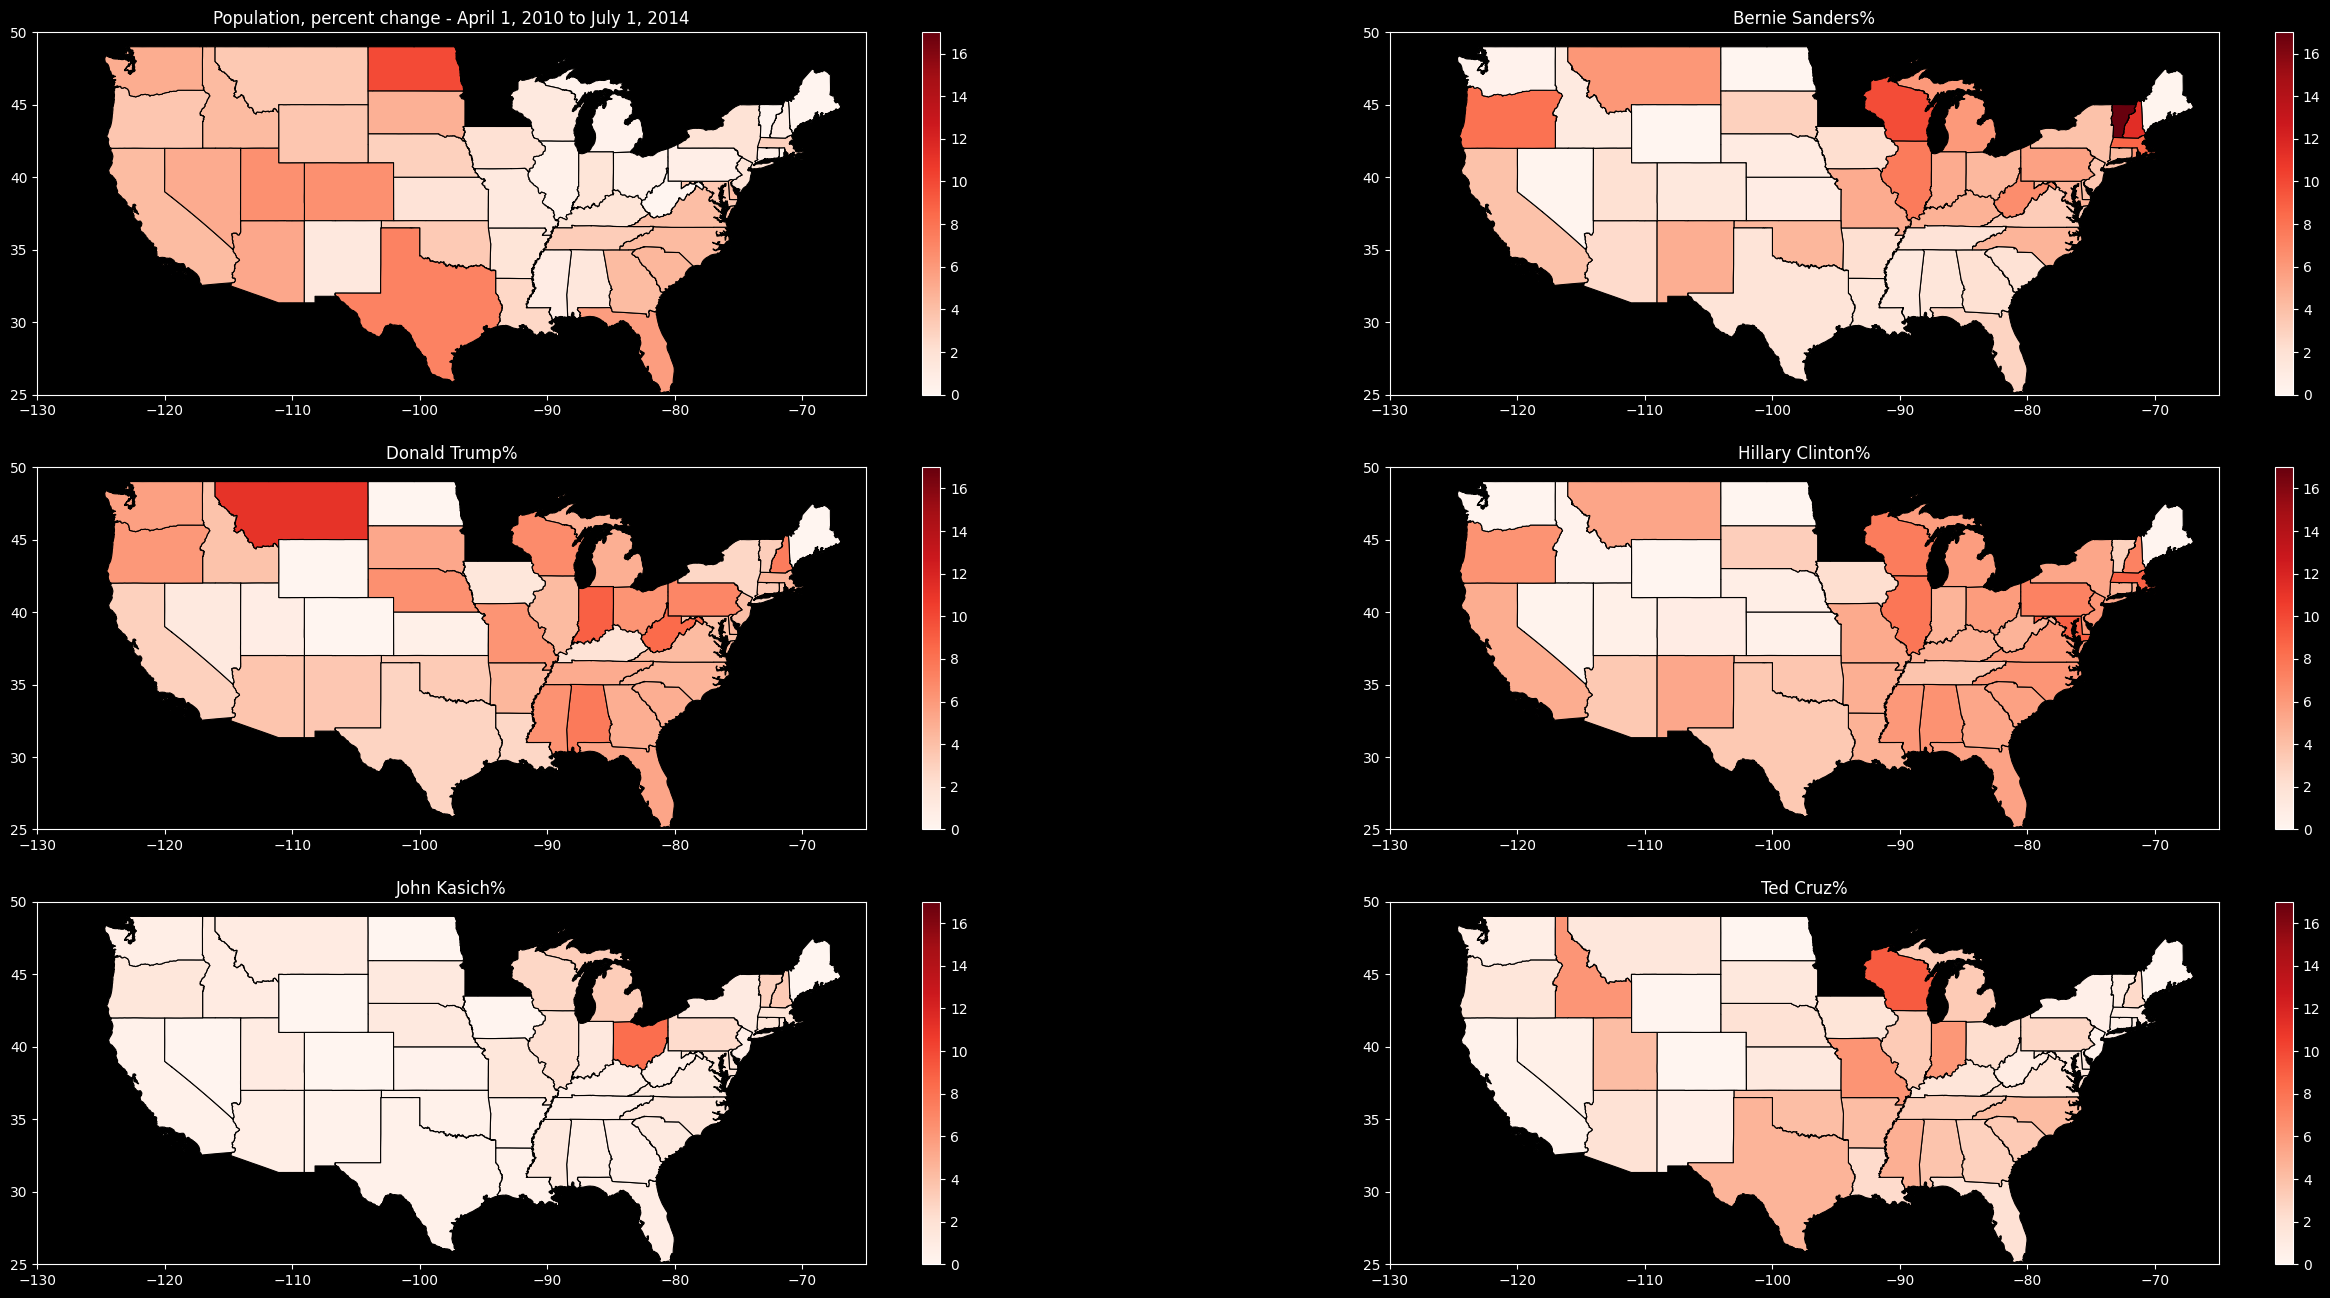

In [50]:
selected_columns = psf.iloc[:, 7:]
num_plots = selected_columns.shape[1]
num_rows = num_plots // 2 
num_cols = 2
fig, axs = plt.subplots(num_rows, num_cols, figsize=(32, 16))
for i, ax in enumerate(axs.flat):
    if i < num_plots:
        column_data = selected_columns.columns[i]  
        plot_pr_map(psf, column=column_data)
        ax.set_xlim(-130, -65)
        ax.set_ylim(25, 50)
        ax.set_title(column_data)

# preparing race data

In [20]:
rsf = prstates['rsf']

In [53]:
isf.corr() #sort_values(by=rsf.columns[0])[rsf.columns[9:11]].plot(kind='bar', figsize=(25,6))

Per capita money income in past 12 months (2013 dollars), 2009-2013   
Per capita money income in past 12 months (2013...                                           1.000000                    \
Median household income, 2009-2013                                                           0.872144                     
Persons below poverty level, percent, 2009-2013                                             -0.590220                     
Bernie Sanders%                                                                              0.194437                     
Donald Trump%                                                                               -0.207526                     
Hillary Clinton%                                                                             0.153024                     
John Kasich%                                                                                 0.079924                     
Ted Cruz%                                                                                   -0.476198                     

                                                    Median household income, 2009-2013   
Per capita money income in past 12 months (2013...                            0.872144  \
Median household income, 2009-2013                                            1.000000   
Persons below poverty level, percent, 2009-2013                              -0.786450   
Bernie Sanders%                                                               0.087678   
Donald Trump%                                                                -0.311077   
Hillary Clinton%                                                              0.005426   
John Kasich%                                                                  0.009522   
Ted Cruz%                                                                    -0.413649   

                                                    Persons below poverty level, percent, 2009-2013   
Per capita money income in past 12 months (2013...                                        -0.590220  \
Median household income, 2009-2013                                                        -0.786450   
Persons below poverty level, percent, 2009-2013                                            1.000000   
Bernie Sanders%                                                                           -0.177233   
Donald Trump%                                                                              0.244498   
Hillary Clinton%                                                                           0.161608   
John Kasich%                                                                              -0.087513   
Ted Cruz%                                                                                  0.346068   

                                                    Bernie Sanders%   
Per capita money income in past 12 months (2013...         0.194437  \
Median household income, 2009-2013                         0.087678   
Persons below poverty level, percent, 2009-2013           -0.177233   
Bernie Sanders%                                            1.000000   
Donald Trump%                                              0.387656   
Hillary Clinton%                                           0.537114   
John Kasich%                                               0.505669   
Ted Cruz%                                                  0.124712   

                                                    Donald Trump%   
Per capita money income in past 12 months (2013...      -0.207526  \
Median household income, 2009-2013                      -0.311077   
Persons below poverty level, percent, 2009-2013          0.244498   
Bernie Sanders%                                          0.387656   
Donald Trump%                                            1.000000   
Hillary Clinton%                                         0.590339   
John Kasich%                                             0.417276   
Ted Cruz%    

In [26]:
df = prstates['psf']
for i in range(5):
    column_name = df.columns[i]
    df[column_name + '%'] = (df[column_name] / df['Population, 2014 estimate']) * 100
#plot_subplots(df, 0, 6) 

In [52]:
isf = states['isf'].join(df.iloc[:, 8:13])
rsf.head()

White alone, percent, 2014   
state                                    
Alabama                           69.7  \
Alaska                            66.9   
Arizona                           83.7   
Arkansas                          79.7   
California                        73.2   

            Black or African American alone, percent, 2014   
state                                                        
Alabama                                               26.7  \
Alaska                                                 3.9   
Arizona                                                4.7   
Arkansas                                              15.6   
California                                             6.5   

            American Indian and Alaska Native alone, percent, 2014   
state                                                                
Alabama                                                   0.7       \
Alaska                                                   14.8        
Arizona                                                   5.3        
Arkansas                                                  1.0        
California                                                1.7        

            Asian alone, percent, 2014   
state                                    
Alabama                            1.3  \
Alaska                             6.1   
Arizona                            3.3   
Arkansas                           1.5   
California                        14.4   

            Native Hawaiian and Other Pacific Islander alone, percent, 2014   
state                                                                         
Alabama                                                   0.1                \
Alaska                                                    1.3                 
Arizona                                                   0.3                 
Arkansas                                                  0.3                 
California                                                0.5                 

            Two or More Races, percent, 2014   
state                                          
Alabama                                  1.5  \
Alaska                                   7.1   
Arizona                                  2.7   
Arkansas                                 1.9   
California                               3.7   

            Hispanic or Latino, percent, 2014   
state                                           
Alabama                                   4.1  \
Alaska                                    6.8   
Arizona                                  30.5   
Arkansas                                  7.0   
California                               38.6   

            White alone, not Hispanic or Latino, percent, 2014   
state                                                            
Alabama                                                  66.2   \
Alaska                                                   61.9    
Arizona                                                  56.2    
Arkansas                                                 73.4    
California                                               38.5    

            Bernie Sanders%  Donald Trump%  Hillary Clinton%  John Kasich%   
state                                                                        
Alabama            1.575439       7.665624          6.391089      0.782987  \
Alaska             0.059723       0.997106          0.013438      0.121075   
Arizona            2.427399       3.712643          3.501412      0.787939   
Arkansas           2.186781       4.488450          4.873972      0.508972   
California         3.870995       3.027715          5.001173      0.455177   

            Ted Cruz%  
state                  
Alabama      3.724355  
Alaska       1.082212  
Arizona      1.963118  
Arkansas     4.175913  
California   0.371432

In [55]:
rsf.corr()

White alone, percent, 2014   
White alone, percent, 2014                                            1.000000  \
Black or African American alone, percent, 2014                       -0.663133   
American Indian and Alaska Native alone, percen...                    0.044984   
Asian alone, percent, 2014                                           -0.634259   
Native Hawaiian and Other Pacific Islander alon...                   -0.577056   
Two or More Races, percent, 2014                                     -0.584478   
Hispanic or Latino, percent, 2014                                    -0.063923   
White alone, not Hispanic or Latino, percent, 2014                    0.815056   
Bernie Sanders%                                                       0.272604   
Donald Trump%                                                         0.102620   
Hillary Clinton%                                                     -0.179395   
John Kasich%                                                          0.138660   
Ted Cruz%                                                             0.036099   

                                                    Black or African American alone, percent, 2014   
White alone, percent, 2014                                                               -0.663133  \
Black or African American alone, percent, 2014                                            1.000000   
American Indian and Alaska Native alone, percen...                                       -0.325118   
Asian alone, percent, 2014                                                               -0.076486   
Native Hawaiian and Other Pacific Islander alon...                                       -0.153296   
Two or More Races, percent, 2014                                                         -0.188397   
Hispanic or Latino, percent, 2014                                                        -0.108670   
White alone, not Hispanic or Latino, percent, 2014                                       -0.474540   
Bernie Sanders%                                                                          -0.167388   
Donald Trump%                                                                             0.197083   
Hillary Clinton%                                                                          0.518070   
John Kasich%                                                                              0.070696   
Ted Cruz%                                                                                 0.257103   

                                                    American Indian and Alaska Native alone, percent, 2014   
White alone, percent, 2014                                                                   0.044984       \
Black or African American alone, percent, 2014                                              -0.325118        
American Indian and Alaska Native alone, percen...                                           1.000000        
Asian alone, percent, 2014                                                                  -0.089519        
Native Hawaiian and Other Pacific Islander alon...                                           0.009484        
Two or More Races, percent, 2014                                                             0.153634        
Hispanic or Latino, percent, 2014                                                            0.193116        
White alone, not Hispanic or Latino, percent, 2014                                          -0.076717        
Bernie Sanders%                                                                             -0.167633        
Donald Trump%                                                                               -0.130670        
Hillary Clinton%                                                                            -0.283636        
John Kasich%                                                                                -0.246619        
Ted Cruz%                                   

<Axes: xlabel='state'>

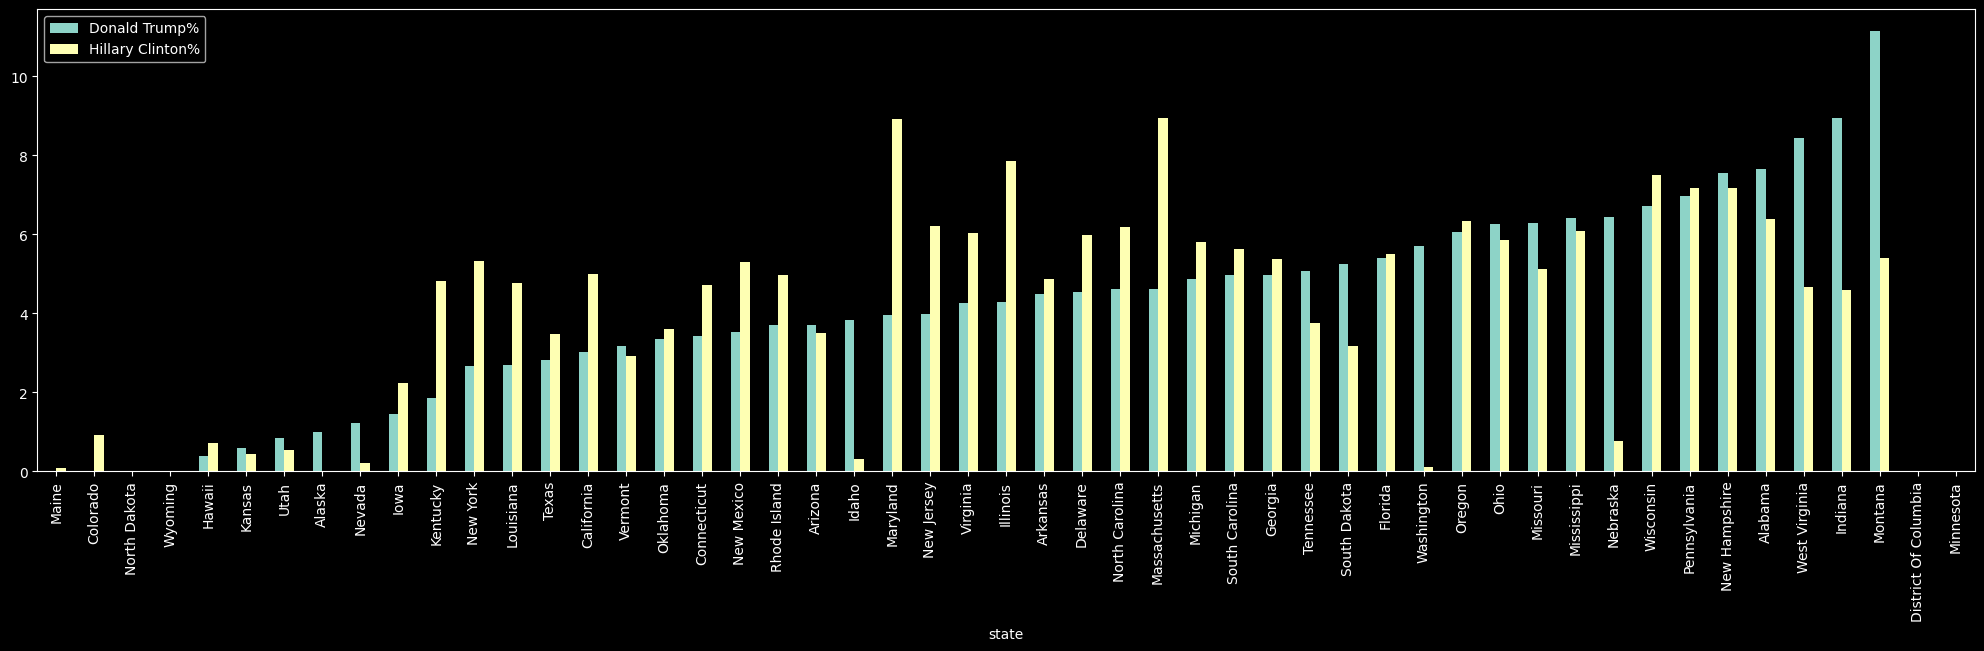

In [85]:
rsf.sort_values(by=rsf.columns[9])[rsf.columns[9:11]].plot(kind='bar', figsize=(25,6))

<Axes: xlabel='state'>

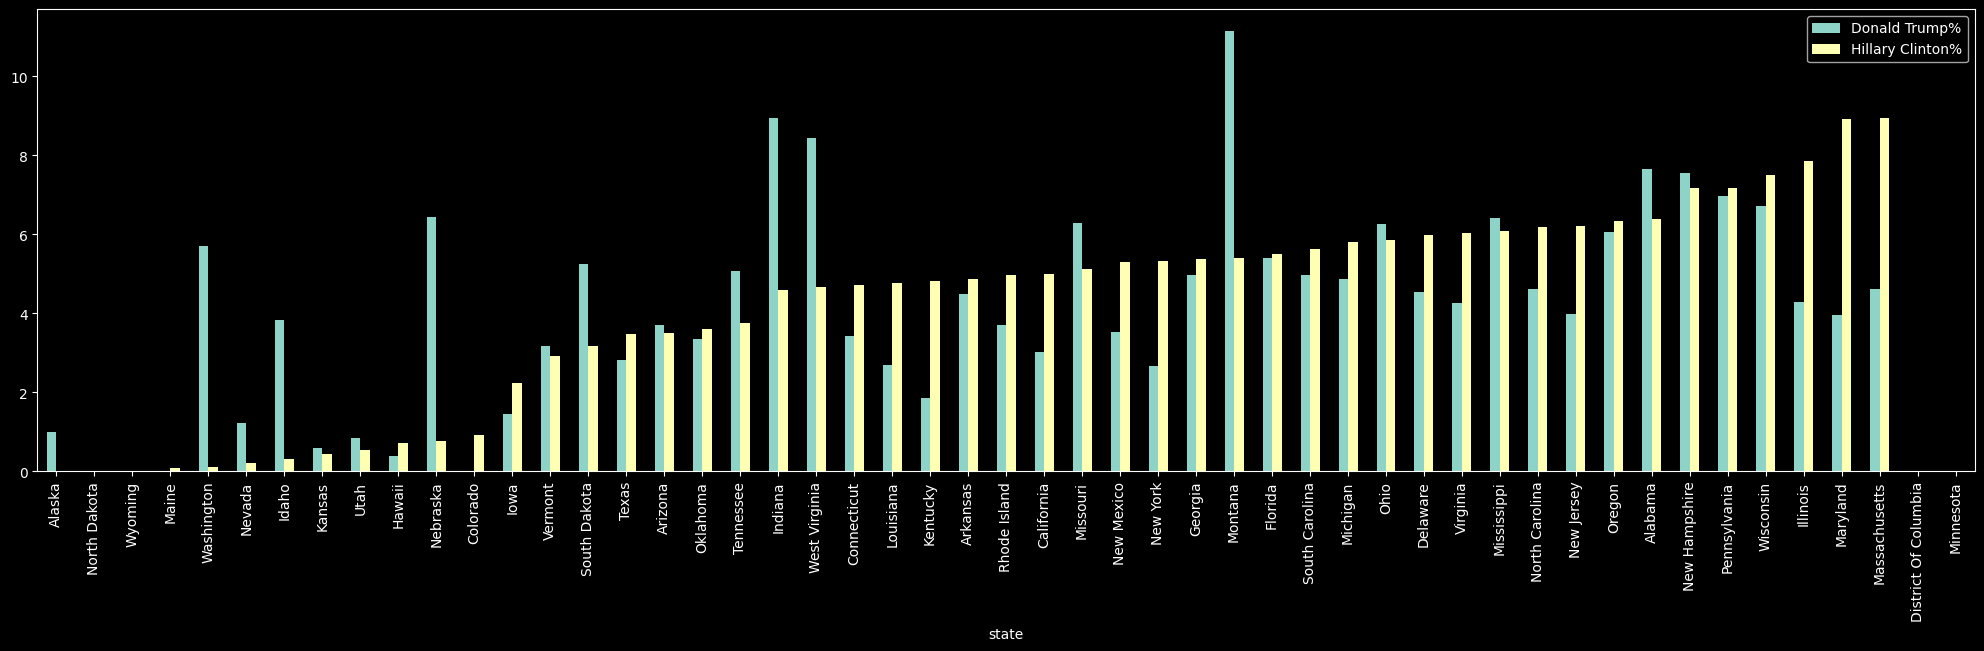

In [86]:
rsf.sort_values(by=rsf.columns[10])[rsf.columns[9:11]].plot(kind='bar', figsize=(25,6))

<Axes: xlabel='state'>

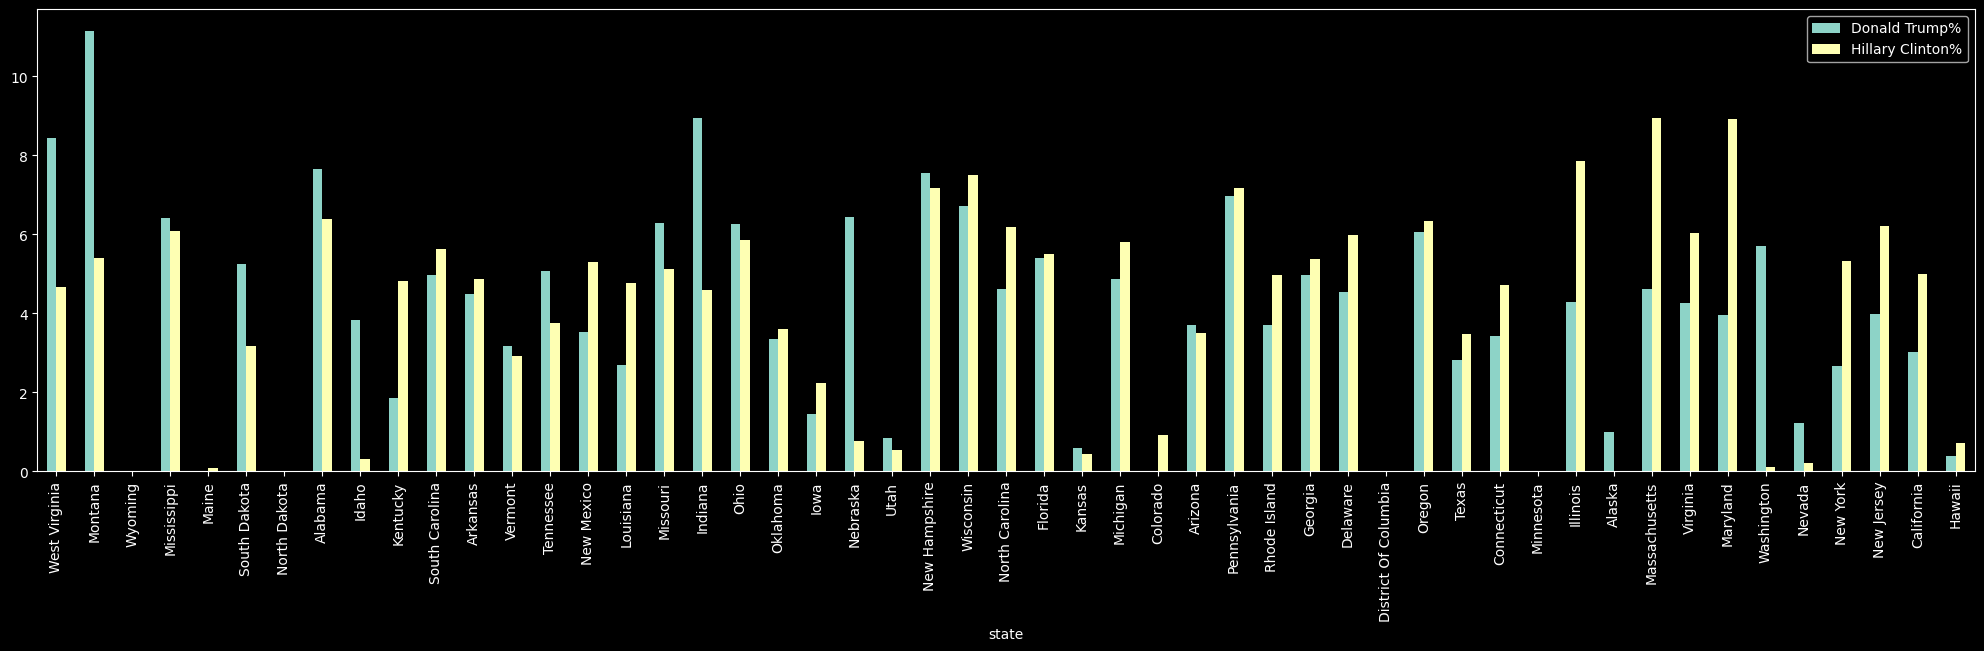

In [93]:
rsf.sort_values(by=rsf.columns[3])[rsf.columns[9:11]].plot(kind='bar', figsize=(25,6))

# County level

In [17]:
pr.groupby(['state_abbreviation', 'county','candidate']).agg({'votes':'sum'}).index.get_level_values(1).nunique()

2633

In [208]:
# Create a pivot table with candidates as columns and votes as values
pivot_table = pr.pivot_table(index=['fips','state_abbreviation', 'county'],
                             columns='candidate',
                             values='votes',
                             aggfunc='sum',
                             fill_value=0)

# Reset the index to make the columns accessible
pivot_table = pivot_table.reset_index()
ccf = cf.rename(columns={'area_name': 'county'})
votes = pivot_table.merge(ccf, on=['state_abbreviation', 'county'], how='inner')

In [7]:
votes = votes.drop([' No Preference', ' Uncommitted','Ben Carson', 'Carly Fiorina', 'Chris Christie', 'Jeb Bush', '''Martin O'Malley''','Mike Huckabee', 'Rand Paul', 'Rand Paul', 'Rick Santorum', 'Marco Rubio', 'fips'], axis = 1)

In [40]:
votes['county'].nunique()

1596

In [209]:
df = pr.merge(ccf, on=['state_abbreviation', 'county'], how='inner')
df['county'].nunique()

1601

In [37]:
pivot_table['fips'].nunique()

4207

In [333]:
df = pivot_table.merge(ccf, on='fips', how='outer').drop([' No Preference', ' Uncommitted'], axis = 1)
#df = df[~df['state_abbreviation_y'].isnull()]
#df[df['county_x'].isnull()]['state_abbreviation_y'].unique()

In [234]:
#df[df['county_y'].isnull()]['state_abbreviation_x'].unique()

array(['AK', 'CT', 'IL', 'KS', 'ME', 'MA', 'ND', 'RI', 'VT', 'WY'],
      dtype=object)

In [334]:
av = df.iloc[:,3:17]
avs = av.sum(axis=1).sum()
av.sum()

Ben Carson           558044.0
Bernie Sanders     11807518.0
Carly Fiorina          3485.0
Chris Christie         3284.0
Donald Trump       13202135.0
Hillary Clinton    15597200.0
Jeb Bush              63101.0
John Kasich         4115040.0
Marco Rubio         3291044.0
Martin O'Malley         752.0
Mike Huckabee          3345.0
Rand Paul              8479.0
Rick Santorum          1782.0
Ted Cruz            7569817.0
dtype: float64

In [335]:
df = df.drop(['Ben Carson', 'Carly Fiorina', 'Chris Christie', 'Jeb Bush', '''Martin O'Malley''','Mike Huckabee', 'Rand Paul', 'Rand Paul', 'Rick Santorum'], axis = 1)

In [342]:
gv = df.iloc[:,3:9]
gv.sum()

Bernie Sanders     11807518.0
Donald Trump       13202135.0
Hillary Clinton    15597200.0
John Kasich         4115040.0
Marco Rubio         3291044.0
Ted Cruz            7569817.0
dtype: float64

In [355]:
mv = df[df['county_y'].isnull()].iloc[:,3:9]
mv.sum()

Bernie Sanders     1474706.0
Donald Trump        642563.0
Hillary Clinton    1474865.0
John Kasich         291558.0
Marco Rubio         171762.0
Ted Cruz            209992.0
dtype: float64

currently miaaing % of votes in county facts

In [354]:
mv.sum(axis=1).sum() / gv.sum(axis=1).sum() * 100

7.6740458020485995

In [356]:
mv.sum() / gv.sum() * 100

Bernie Sanders     12.489551
Donald Trump        4.867114
Hillary Clinton     9.455960
John Kasich         7.085180
Marco Rubio         5.219073
Ted Cruz            2.774070
dtype: float64

In [360]:
df[df['county_y'].isnull()][['fips','state_abbreviation_x', 'county_x']]

fips state_abbreviation_x                county_x
2798  90200101.0                   AK  State House District 1
2799  90200102.0                   AK  State House District 2
2800  90200103.0                   AK  State House District 3
2801  90200104.0                   AK  State House District 4
2802  90200105.0                   AK  State House District 5
...          ...                  ...                     ...
4202  95600032.0                   WY        Campbell-Johnson
4203  95600033.0                   WY            Crook-Weston
4204  95600034.0                   WY       Converse-Niobrara
4205  95600035.0                   WY           Goshen-Platte
4206  95600036.0                   WY                 Laramie

[1409 rows x 3 columns]

In [361]:
df[df['county_x'].isnull()][['fips','state_abbreviation_y', 'county_y']]

fips state_abbreviation_y                    county_y
4207      0.0                  NaN               United States
4208   1000.0                  NaN                     Alabama
4209   2000.0                  NaN                      Alaska
4210   2013.0                   AK      Aleutians East Borough
4211   2016.0                   AK  Aleutians West Census Area
...       ...                  ...                         ...
4599  51515.0                   VA                Bedford city
4600  53000.0                  NaN                  Washington
4601  54000.0                  NaN               West Virginia
4602  55000.0                  NaN                   Wisconsin
4603  56000.0                  NaN                     Wyoming

[397 rows x 3 columns]

In [362]:
gdf = df.dropna()

In [366]:
gdf[gdf['county_x'] != gdf['county_y']]

fips state_abbreviation_x        county_x  Bernie Sanders   
143    5123.0                   AR   Saint Francis           354.0  \
574   17039.0                   IL          DeWitt           659.0   
597   17085.0                   IL       JoDaviess          1225.0   
909   21123.0                   KY           LaRue           910.0   
968   22001.0                   LA          Acadia          1087.0   
...       ...                  ...             ...             ...   
2604  51800.0                   VA         Suffolk          1893.0   
2605  51810.0                   VA  Virginia Beach         12969.0   
2606  51820.0                   VA      Waynesboro           769.0   
2607  51830.0                   VA    Williamsburg          1197.0   
2608  51840.0                   VA      Winchester           900.0   

      Donald Trump  Hillary Clinton  John Kasich  Marco Rubio  Ted Cruz   
143          598.0           1912.0         19.0        236.0     494.0  \
574         1577.0            561.0        402.0        255.0    1489.0   
597         1666.0           1315.0        846.0        391.0    1153.0   
909          264.0            612.0         76.0        110.0     275.0   
968         1694.0           1862.0        129.0        403.0    1454.0   
...            ...              ...          ...          ...       ...   
2604        3732.0           7533.0        641.0       2952.0    1372.0   
2605       22139.0          22352.0       4962.0      18068.0    6720.0   
2606         910.0            788.0        230.0        817.0     580.0   
2607         336.0           1159.0        344.0        630.0     148.0   
2608         871.0            949.0        294.0        843.0     475.0   

                 county_y  ... Hispanic-owned firms, percent, 2007   
143           St. Francis  ...                                 1.4  \
574               De Witt  ...                                 0.0   
597            Jo Daviess  ...                                 0.0   
909                 Larue  ...                                 0.0   
968         Acadia Parish  ...                                 1.4   
...                   ...  ...                                 ...   
2604         Suffolk city  ...                                 0.0   
2605  Virginia Beach city  ...                                 2.4   
2606      Waynesboro city  ...                                 0.0   
2607    Williamsburg city  ...                                 0.0   
2608      Winchester city  ...                                 0.0   

      Women-owned firms, percent, 2007   
143                               38.8  \
574                                0.0   
597                               23.0   
909                                0.0   
968                               25.4   
...                                ...   
2604                              29.6   
2605                              31.6   
2606                              24.8   
2607                              22.7   
2608                              20.7   

      Manufacturers shipments, 2007 ($1,000)   
143                                      0.0  \
574                                      0.0   
597                                 419517.0   
909                                  90029.0   
968                                      0.0   
...                                      ...   
2604                               1307801.0   
2605                               1806461.0   
2606                                759893.0   
2607                                     0.0   
2608                                     0.0   

      Merchant wholesaler sales, 2007 ($1,000)  Retail sales, 2007 ($1,000)   
143                                        0.0                     353772.0  \
574                                   248857.0                     188199.0   
597                                   120531.0                     310735.0   
909                         

In [386]:
gdf = gdf.set_index('fips') 

In [606]:
vfdf = gdf.iloc[:, 0:8]
pfdf = gdf.iloc[:, 11:15]
ifdf = gdf.iloc[:,39:42]
afdf = gdf.iloc[:,14:17]
rfdf = gdf.iloc[:,18:25]

In [412]:
def cdf (df2):
    return vfdf.merge(df2, left_index = True, right_index=True)

# income

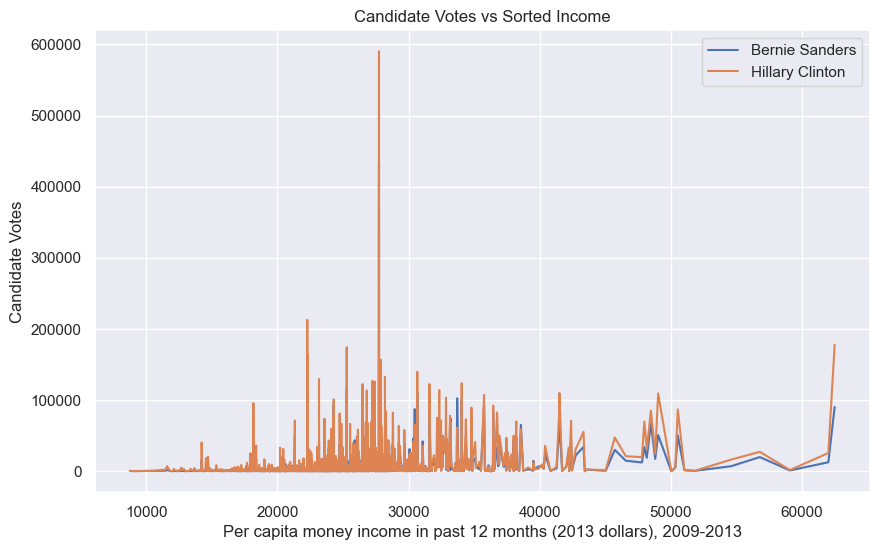

In [723]:
df = cdf(ifdf)
import matplotlib.pyplot as plt

# Sort the DataFrame by income in ascending order
sorted_df = df.sort_values(by='Per capita money income in past 12 months (2013 dollars), 2009-2013')

# Extract the candidate columns
#candidate_cols = ['Bernie Sanders','Donald Trump', 'Hillary Clinton', 'John Kasich', 'Marco Rubio', 'Ted Cruz']
candidate_cols = ['Bernie Sanders', 'Hillary Clinton']
candidates_df = sorted_df[candidate_cols]

# Plot the sorted income values as x and candidates as y
plt.figure(figsize=(10, 6))
plt.plot(sorted_df['Per capita money income in past 12 months (2013 dollars), 2009-2013'], candidates_df)
plt.xlabel('Per capita money income in past 12 months (2013 dollars), 2009-2013')
plt.ylabel('Candidate Votes')
plt.legend(candidate_cols)
plt.title('Candidate Votes vs Sorted Income')
plt.show()


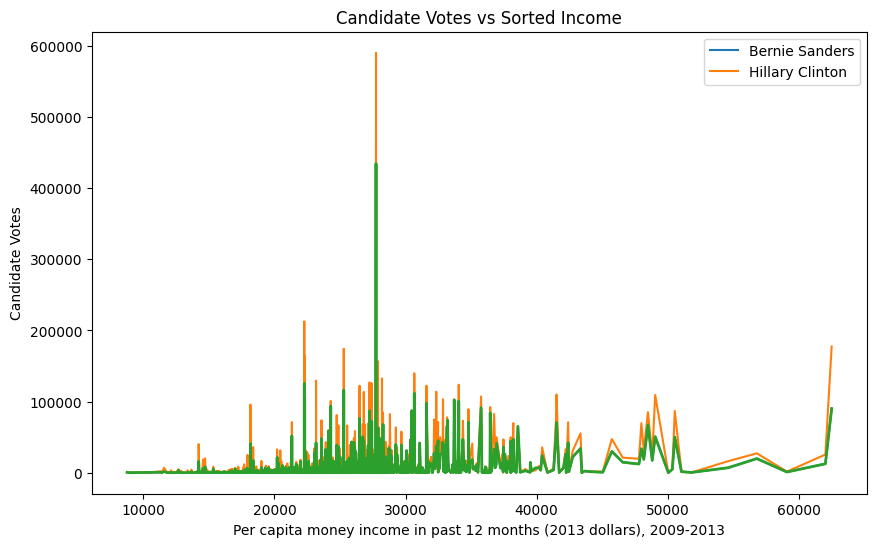

In [430]:
import matplotlib.pyplot as plt

# Sort the DataFrame by income in ascending order
sorted_df = df.sort_values(by='Per capita money income in past 12 months (2013 dollars), 2009-2013')

# Extract the candidate columns
candidate_cols = ['Bernie Sanders', 'Hillary Clinton']
candidates_df = sorted_df[candidate_cols]

# Plot the sorted income values as x and candidates as y
plt.figure(figsize=(10, 6))
plt.plot(sorted_df['Per capita money income in past 12 months (2013 dollars), 2009-2013'], candidates_df)

# Adjust the line style, line width, or line color for Bernie Sanders
plt.plot(sorted_df['Per capita money income in past 12 months (2013 dollars), 2009-2013'], sorted_df['Bernie Sanders'], linewidth=2)

plt.xlabel('Per capita money income in past 12 months (2013 dollars), 2009-2013')
plt.ylabel('Candidate Votes')
plt.legend(candidate_cols)
plt.title('Candidate Votes vs Sorted Income')
plt.show()


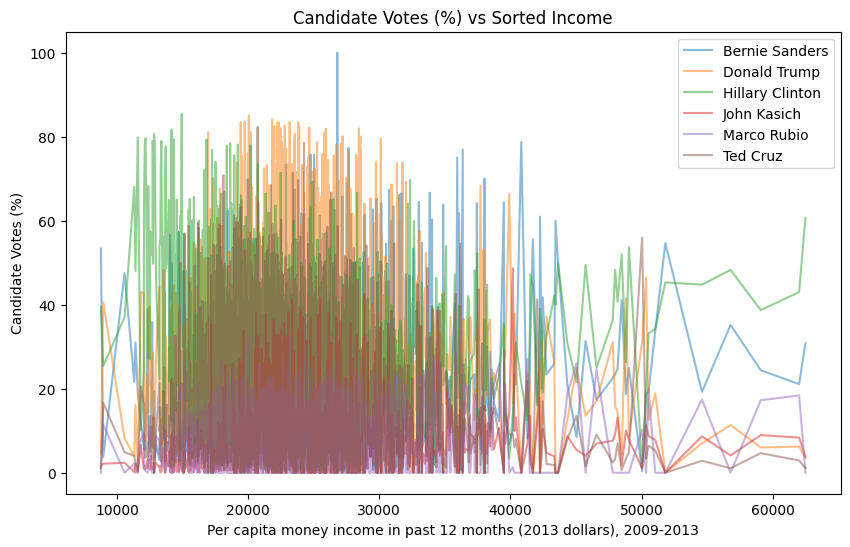

In [435]:
import matplotlib.pyplot as plt

# Calculate the total votes for each candidate
df['Total Votes'] = df[candidate_cols].sum(axis=1)

# Calculate the percentage of votes for each candidate
for candidate in candidate_cols:
    df[f'{candidate} (%)'] = df[candidate] / df['Total Votes'] * 100

# Sort the DataFrame by income in ascending order
sorted_df = df.sort_values(by='Per capita money income in past 12 months (2013 dollars), 2009-2013')

# Extract the candidate percentage columns
candidate_percent_cols = [f'{candidate} (%)' for candidate in candidate_cols]
candidates_df = sorted_df[candidate_percent_cols]

# Plot the sorted income values as x and candidate percentages as y
plt.figure(figsize=(10, 6))
plt.plot(sorted_df['Per capita money income in past 12 months (2013 dollars), 2009-2013'], candidates_df, alpha=0.5)

plt.xlabel('Per capita money income in past 12 months (2013 dollars), 2009-2013')
plt.ylabel('Candidate Votes (%)')
plt.legend(candidate_cols)
plt.title('Candidate Votes (%) vs Sorted Income')
plt.show()


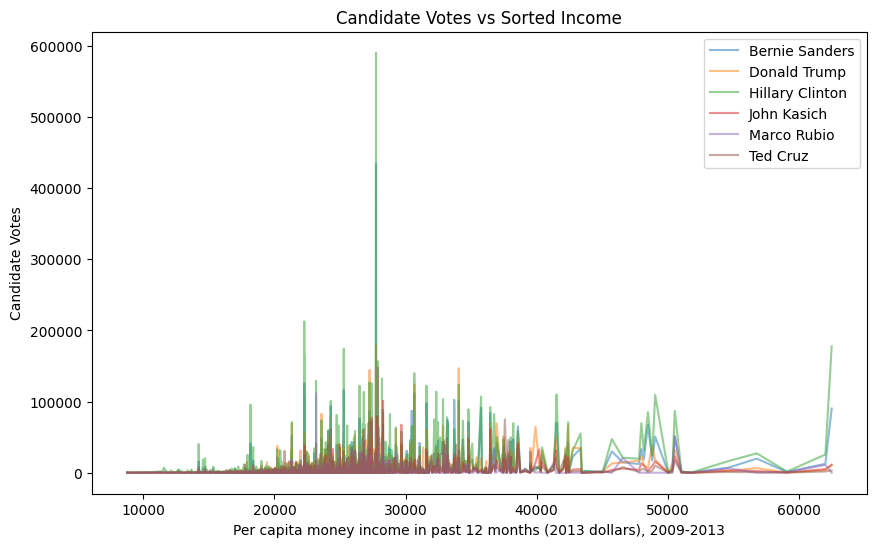

In [438]:
import matplotlib.pyplot as plt

# Sort the DataFrame by income in ascending order
sorted_df = df.sort_values(by='Per capita money income in past 12 months (2013 dollars), 2009-2013')

# Extract the candidate columns
candidate_cols = ['Bernie Sanders', 'Donald Trump', 'Hillary Clinton', 'John Kasich', 'Marco Rubio', 'Ted Cruz']
candidates_df = sorted_df[candidate_cols]

# Plot the sorted income values as x and candidates as y with transparency
plt.figure(figsize=(10, 6))
for col in candidate_cols:
    plt.plot(sorted_df['Per capita money income in past 12 months (2013 dollars), 2009-2013'], candidates_df[col], alpha=0.5)

plt.xlabel('Per capita money income in past 12 months (2013 dollars), 2009-2013')
plt.ylabel('Candidate Votes')
plt.legend(candidate_cols)
plt.title('Candidate Votes vs Sorted Income')
plt.show()


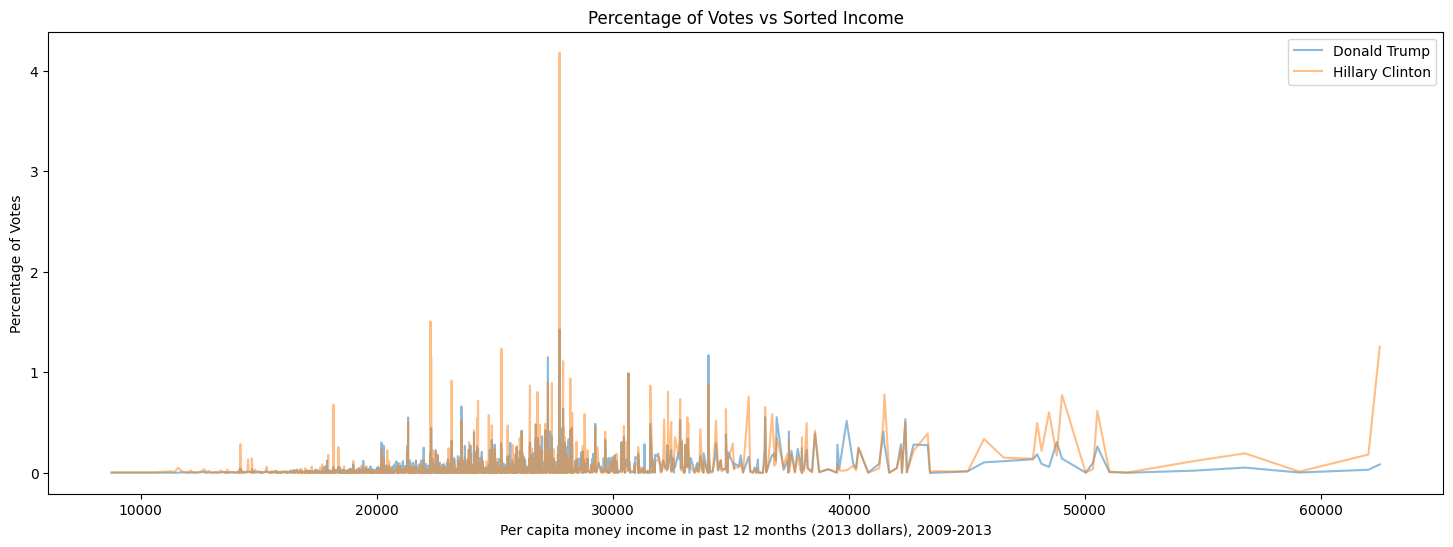

In [536]:
import matplotlib.pyplot as plt

# Calculate the total votes for each candidate
total_votes = df[candidate_cols].sum()

# Calculate the percentage of votes for each candidate
percent_votes = (df[candidate_cols] / total_votes) * 100

# Sort the DataFrame by income in ascending order
sorted_df = df.sort_values(by='Per capita money income in past 12 months (2013 dollars), 2009-2013')

# Extract the candidate columns
candidates_df = percent_votes.loc[sorted_df.index]

# Plot the sorted income values as x and candidates as y with transparency
plt.figure(figsize=(18, 6))
for col in candidate_cols:
    plt.plot(sorted_df['Per capita money income in past 12 months (2013 dollars), 2009-2013'], candidates_df[col], alpha=0.5)

plt.xlabel('Per capita money income in past 12 months (2013 dollars), 2009-2013')
plt.ylabel('Percentage of Votes')
plt.legend(candidate_cols)
plt.title('Percentage of Votes vs Sorted Income')
plt.show()


In [727]:
df

state_abbreviation_x    county_x  Bernie Sanders  Donald Trump   
fips                                                                     
1001.0                    AL     Autauga           544.0        5387.0  \
1003.0                    AL     Baldwin          2694.0       23618.0   
1005.0                    AL     Barbour           222.0        1710.0   
1007.0                    AL        Bibb           246.0        1959.0   
1009.0                    AL      Blount           395.0        7390.0   
...                      ...         ...             ...           ...   
56037.0                   WY  Sweetwater            12.0           0.0   
56039.0                   WY       Teton             9.0           0.0   
56041.0                   WY       Uinta             5.0           0.0   
56043.0                   WY    Washakie             1.0           0.0   
56045.0                   WY      Weston             1.0           0.0   

         Hillary Clinton  John Kasich  Marco Rubio  Ted Cruz   
fips                                                           
1001.0            2387.0        421.0       1785.0    2482.0  \
1003.0            5290.0       2987.0       9703.0    8571.0   
1005.0            2567.0        123.0        498.0     609.0   
1007.0             942.0         84.0        444.0    1011.0   
1009.0             564.0        337.0       1843.0    3698.0   
...                  ...          ...          ...       ...   
56037.0             10.0          0.0          0.0       0.0   
56039.0              6.0          0.0          0.0       0.0   
56041.0              4.0          0.0          0.0       0.0   
56043.0              2.0          0.0          0.0       0.0   
56045.0              1.0          0.0          0.0       0.0   

         Per capita money income in past 12 months (2013 dollars), 2009-2013   
fips                                                                           
1001.0                                             24571.0                    \
1003.0                                             26766.0                     
1005.0                                             16829.0                     
1007.0                                             17427.0                     
1009.0                                             20730.0                     
...                                                    ...                     
56037.0                                            30517.0                     
56039.0                                            43444.0                     
56041.0                                            25513.0                     
56043.0                                            28308.0                     
56045.0                                            28764.0                     

         Median household income, 2009-2013   
fips                                          
1001.0                              53682.0  \
1003.0                              50221.0   
1005.0                              32911.0   
1007.0                              36447.0   
1009.0                              44145.0   
...                                     ...   
56037.0                             71525.0   
56039.0                             68078.0   
56041.0                             58515.0   
56043.0                             47104.0   
56045.0                             55461.0   

         Persons below poverty level, percent, 2009-2013  
fips                                                      
1001.0                                              12.1  
1003.0                                              13.9  
1005.0                                              26.7  
1007.0                                              18.1  
1009.0                                              15.8  
...                                                  ...  
56037.0                                             11.3  
56039.0                     

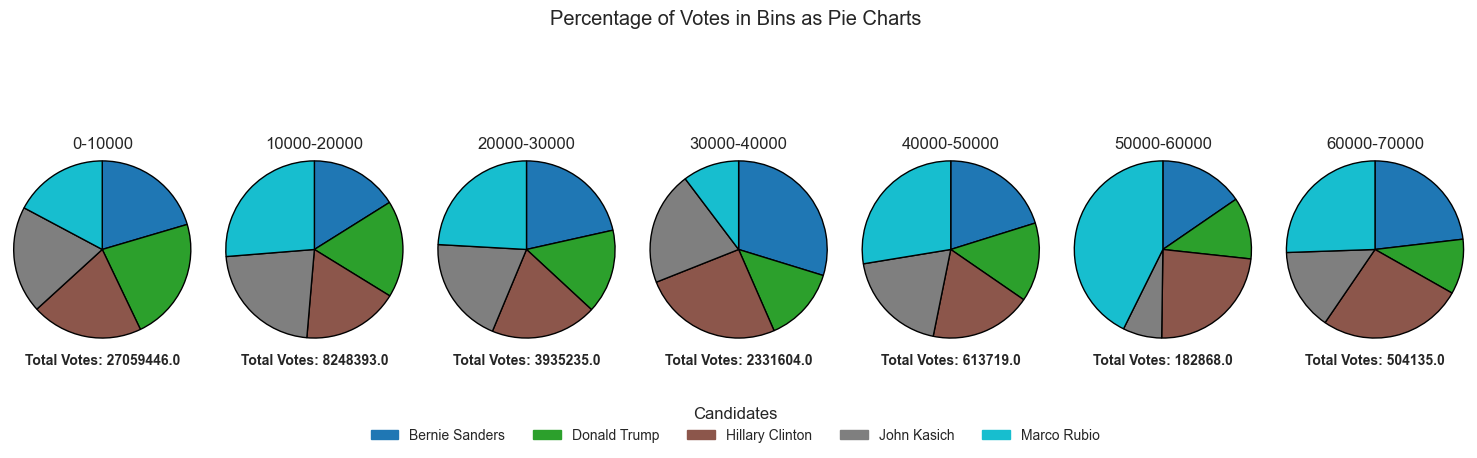

In [726]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Define the bin edges for income
bin_edges = range(0, int(df['Per capita money income in past 12 months (2013 dollars), 2009-2013'].max()) + 10000, 10000)


# Define the candidate columns
candidate_cols = ['Bernie Sanders', 'Donald Trump', 'Hillary Clinton', 'John Kasich', 'Marco Rubio', ]

# Calculate the percentage of votes for each candidate within each income bin
total_votes = df[candidate_cols].sum()
percent_votes = (df[candidate_cols] / total_votes) * 100

# Create a list to store pie chart data
pie_data = []

# Iterate over the bin edges
for i in range(len(bin_edges) - 1):
    # Filter the data for the current income bin
    votes_in_bin = df[(df.iloc[:, 7] >= bin_edges[i]) & (df.iloc[:, 7] < bin_edges[i + 1])]
    
    # Calculate the mean percentage of votes for each candidate in the bin
    pie_values = percent_votes.loc[votes_in_bin.index].mean()
    pie_data.append(pie_values)
    
    # Calculate the overall vote count for the bin
    vote_count = votes_in_bin[candidate_cols].sum().sum()
    pie_data.append(vote_count)

# Create subplots to display the pie charts
fig, axs = plt.subplots(1, len(pie_data) // 2, figsize=(15, 5))

# Generate colors for the candidates
colors = plt.cm.tab10(np.linspace(0, 1, len(candidate_cols)))

# Iterate over the pie chart data and create the pie charts
for i, pie_values in enumerate(pie_data[::2]):
    ax = axs[i]
    ax.pie(pie_values, startangle=90, counterclock=False, radius=1.2, wedgeprops={'edgecolor': 'black'}, colors=colors)
    ax.set_title(f'{i * 10000}-{(i + 1) * 10000}')
    
    vote_count = pie_data[i * 2 + 1]
    vote_text = f'Total Votes: {vote_count}'
    ax.text(0, -1.5, vote_text, horizontalalignment='center', verticalalignment='center', fontsize=10, weight='bold')

# Add a legend with candidate labels
legend_handles = [mpatches.Patch(color=colors[i], label=candidate) for i, candidate in enumerate(candidate_cols)]
fig.legend(handles=legend_handles, loc='center', bbox_to_anchor=(0.5, 0.15), bbox_transform=plt.gcf().transFigure,
           ncol=len(candidate_cols), frameon=False, title='Candidates', prop={'size': 10})

# Adjust the layout and display the plot
fig.tight_layout(rect=[0, 0.2, 1, 0.8])
plt.suptitle('Percentage of Votes in Bins as Pie Charts')
plt.show()


In [736]:
bin_edges = range(0, int(df['Median household income, 2009-2013'].max()) + 10000, 10000)
bin_edges

range(0, 132238, 10000)

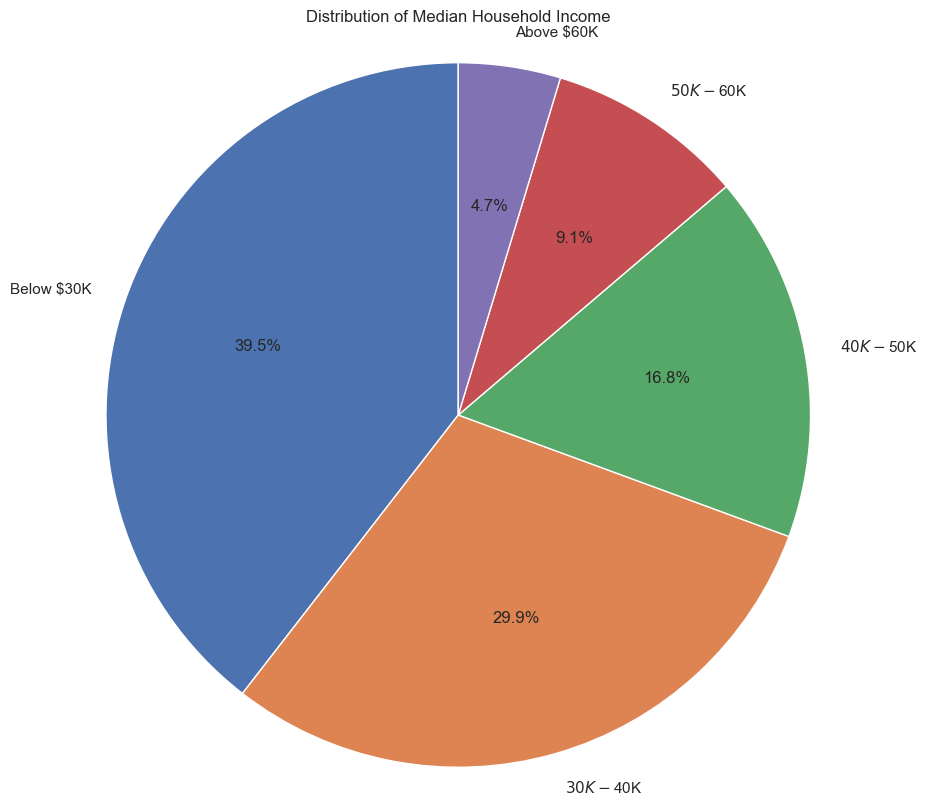

In [741]:
import pandas as pd
import matplotlib.pyplot as plt

# Select the column of interest (Median household income, 2009-2013)
income_column = df['Median household income, 2009-2013']

# Create labels for the pie chart
labels = ['Below $30K', '$30K-$40K', '$40K-$50K', '$50K-$60K', 'Above $60K']

# Create bins for the income ranges
bins = [0, 30000, 40000, 50000, 60000, income_column.max()]

# Group the data into the bins
income_groups = pd.cut(income_column, bins=bins, labels=labels, right=False)

# Count the number of occurrences in each income group
group_counts = income_groups.value_counts()

# Plot the pie chart
plt.pie(group_counts, labels=labels, autopct='%1.1f%%', startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.title('Distribution of Median Household Income')
plt.show()


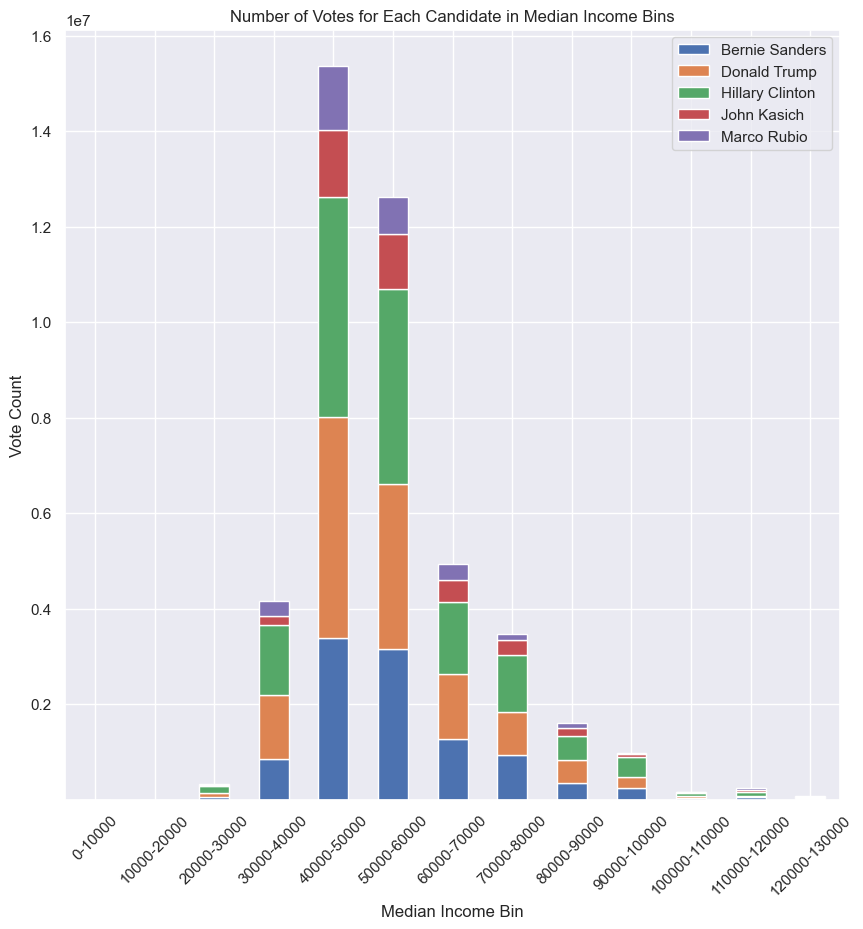

In [742]:
import pandas as pd
import matplotlib.pyplot as plt

# Define the bin edges for median income
bin_edges = range(0, int(df['Median household income, 2009-2013'].max()) + 10000, 10000)

# Define the candidate columns
candidate_cols = ['Bernie Sanders', 'Donald Trump', 'Hillary Clinton', 'John Kasich', 'Marco Rubio']

# Create a list to store the vote counts for each candidate
vote_counts = []

# Iterate over the bin edges
for i in range(len(bin_edges) - 1):
    # Filter the data for the current median income bin
    votes_in_bin = df[(df['Median household income, 2009-2013'] >= bin_edges[i]) &
                      (df['Median household income, 2009-2013'] < bin_edges[i + 1])]
    
    # Calculate the vote count for each candidate in the bin
    vote_count = votes_in_bin[candidate_cols].sum()
    vote_counts.append(vote_count)

# Convert the vote counts into a DataFrame
votes_df = pd.DataFrame(vote_counts, columns=candidate_cols)

# Plot the bar chart
votes_df.plot(kind='bar', stacked=True)
plt.xlabel('Median Income Bin')
plt.ylabel('Vote Count')
plt.title('Number of Votes for Each Candidate in Median Income Bins')
plt.xticks(range(len(bin_edges) - 1), [f'{i * 10000}-{(i + 1) * 10000}' for i in range(len(bin_edges) - 1)], rotation=45)
plt.legend()
plt.show()


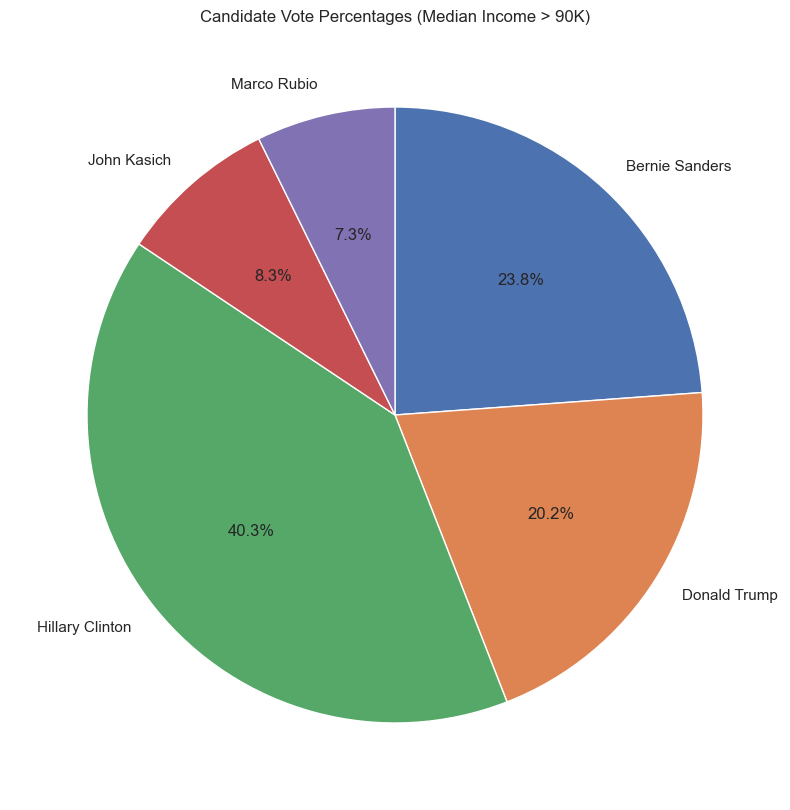

In [754]:
import pandas as pd
import matplotlib.pyplot as plt

# Filter the data for values above 90K
filtered_data = df[df['Median household income, 2009-2013'] > 90000]

# Get the candidate vote percentages for the filtered data
vote_percentages = filtered_data[candidate_cols].sum() / filtered_data[candidate_cols].sum().sum()

# Create a pie chart for the vote percentages
fig, ax = plt.subplots()
ax.pie(vote_percentages, labels=candidate_cols, startangle=90, counterclock=False, autopct='%1.1f%%')
ax.set_title('Candidate Vote Percentages (Median Income > 90K)')

# Display the plot
plt.show()


In [755]:
filtered_data

state_abbreviation_x        county_x  Bernie Sanders  Donald Trump   
fips                                                                         
6041.0                    CA           Marin         19848.0        6409.0  \
6085.0                    CA     Santa Clara         70468.0       35568.0   
8035.0                    CO         Douglas          2347.0           0.0   
24009.0                   MD         Calvert          3247.0        6360.0   
24017.0                   MD         Charles          6246.0        6238.0   
24027.0                   MD          Howard         18752.0       10994.0   
24031.0                   MD      Montgomery         50741.0       17644.0   
34019.0                   NJ       Hunterdon          5047.0       12450.0   
34027.0                   NJ          Morris         17259.0       38252.0   
34035.0                   NJ        Somerset         12235.0       16861.0   
35028.0                   NM      Los Alamos          1404.0         787.0   
36059.0                   NY          Nassau         42301.0       66989.0   
36079.0                   NY          Putnam          3573.0        5757.0   
51013.0                   VA       Arlington         12541.0        3698.0   
51059.0                   VA         Fairfax         50217.0       32751.0   
51107.0                   VA         Loudoun         14719.0       14420.0   
51153.0                   VA  Prince William         14696.0       15345.0   
51179.0                   VA        Stafford          4140.0        7339.0   
51600.0                   VA    Fairfax City          1243.0         760.0   
51610.0                   VA    Falls Church          1000.0         246.0   

         Hillary Clinton  John Kasich  Marco Rubio  Ted Cruz   
fips                                                           
6041.0           27238.0       2318.0          0.0     596.0  \
6085.0          109963.0      10894.0          0.0    6012.0   
8035.0            2342.0          0.0          0.0       0.0   
24009.0           5168.0       1898.0          0.0    2240.0   
24017.0          15132.0       1535.0          0.0    2220.0   
24027.0          30873.0       9909.0          0.0    5282.0   
24031.0         109304.0      15910.0          0.0    9942.0   
34019.0           5373.0       3051.0          0.0     898.0   
34027.0          24226.0       9296.0          0.0    3133.0   
34035.0          19667.0       4136.0          0.0    1345.0   
35028.0           1424.0        326.0          0.0     220.0   
36059.0          70947.0      21682.0          0.0    9325.0   
36079.0           3477.0       1509.0          0.0     915.0   
51013.0          25561.0       4971.0      10944.0    1734.0   
51059.0          86898.0      22862.0      52257.0   16888.0   
51107.0          21171.0       5885.0      20845.0    7696.0   
51153.0          26439.0       4328.0      15537.0    7946.0   
51179.0           6437.0       1666.0       6295.0    3507.0   
51600.0           1840.0        520.0       1124.0     484.0   
51610.0           1587.0        367.0        707.0     191.0   

         Per capita money income in past 12 months (2013 dollars), 2009-2013   
fips                                                                           
6041.0                                             56791.0                    \
6085.0                                             41513.0                     
8035.0                                             43634.0                     
24009.0                                            38260.0                     
24017.0                                            37277.0                     
24027.0                                            48172.0                     
24031.0                                            49038.0                     
34019.0                                            50349.0                     
34027.0                                            48814.0                     
34

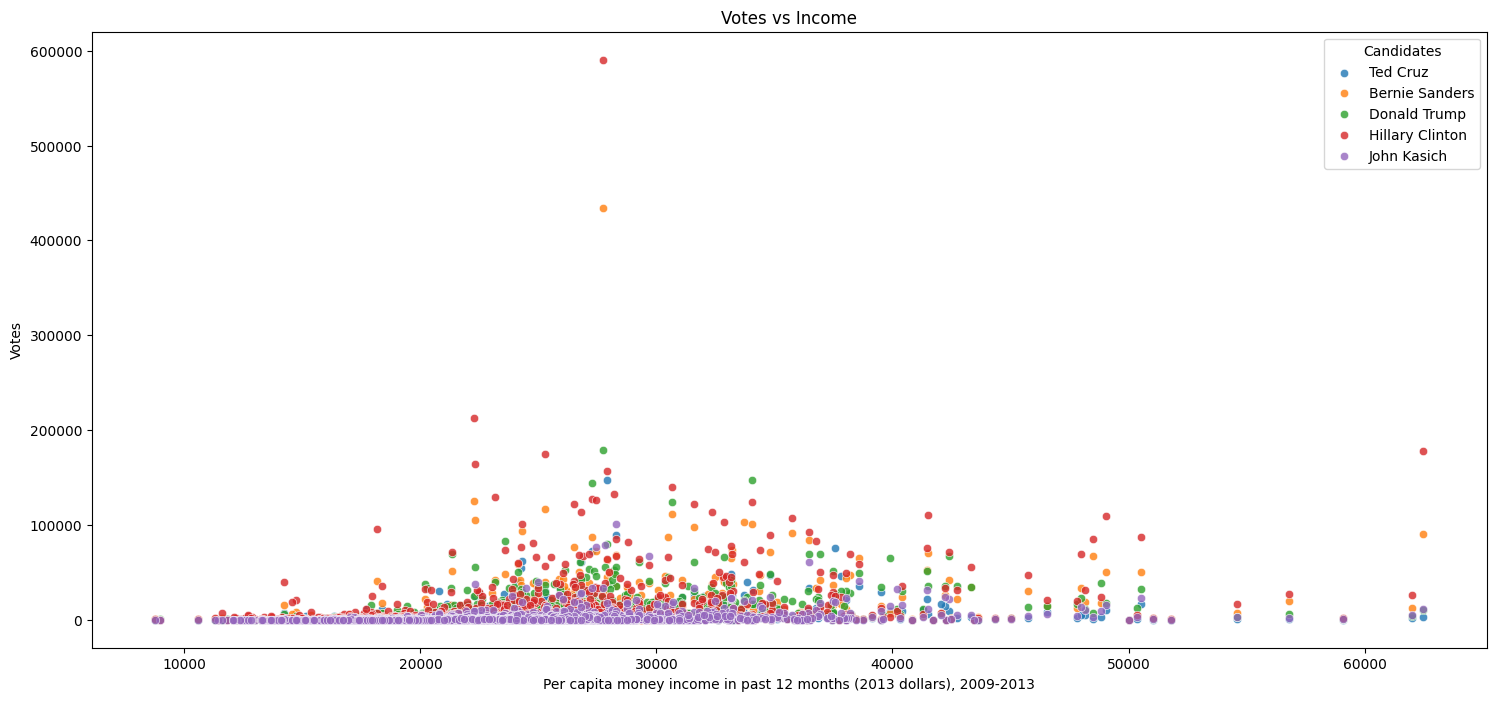

In [561]:
import seaborn as sns
import matplotlib.pyplot as plt

x = df['Per capita money income in past 12 months (2013 dollars), 2009-2013']
candidate_cols = ['Ted Cruz','Bernie Sanders', 'Donald Trump', 'Hillary Clinton', 'John Kasich']

plt.figure(figsize=(18, 8))

for i, candidate in enumerate(candidate_cols):
    y = df[candidate]
    sns.scatterplot(x=x, y=y, color=f'C{i}', alpha=0.8, label=candidate)

plt.xlabel('Per capita money income in past 12 months (2013 dollars), 2009-2013')
plt.ylabel('Votes')
plt.title('Votes vs Income')
plt.legend(title='Candidates')

plt.show()


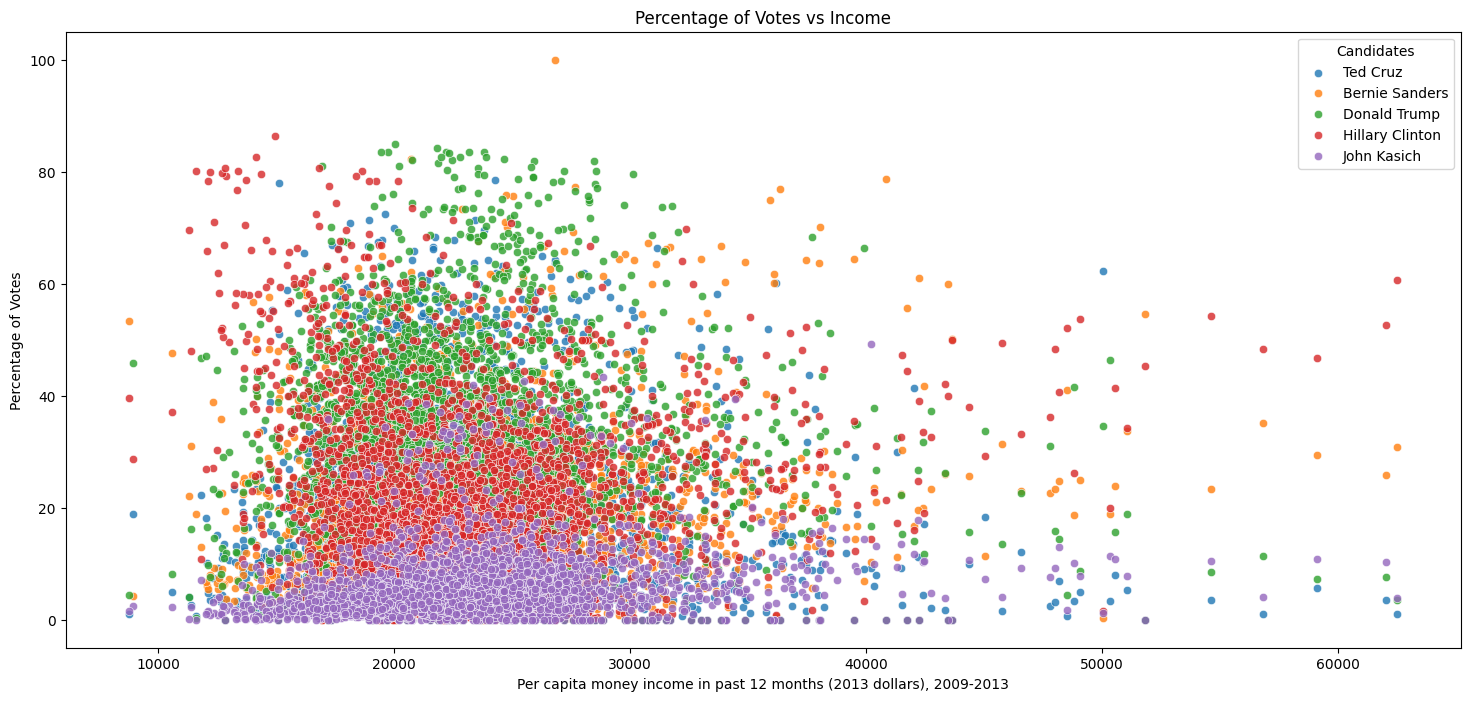

In [564]:
import seaborn as sns
import matplotlib.pyplot as plt

x = df['Per capita money income in past 12 months (2013 dollars), 2009-2013']
candidate_cols = ['Ted Cruz', 'Bernie Sanders', 'Donald Trump', 'Hillary Clinton', 'John Kasich']

plt.figure(figsize=(18, 8))

for i, candidate in enumerate(candidate_cols):
    y = df[candidate] / df[candidate_cols].sum(axis=1) * 100  # Calculate percentage of votes
    sns.scatterplot(x=x, y=y, color=f'C{i}', alpha=0.8, label=candidate)

plt.xlabel('Per capita money income in past 12 months (2013 dollars), 2009-2013')
plt.ylabel('Percentage of Votes')
plt.title('Percentage of Votes vs Income')
plt.legend(title='Candidates')

plt.show()


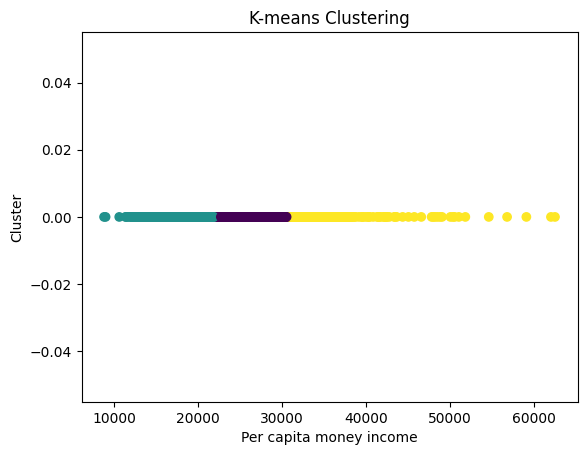

In [556]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Load the data
data = df
# Select the feature for clustering
X = data[['Per capita money income in past 12 months (2013 dollars), 2009-2013']]

# Perform K-means clustering
kmeans = KMeans(n_clusters=3, n_init=10)
clusters = kmeans.fit_predict(X)

# Add the cluster labels to the data
data['Cluster'] = clusters

# Plot the data points with cluster labels
plt.scatter(data['Per capita money income in past 12 months (2013 dollars), 2009-2013'], [0] * len(data), c=data['Cluster'], cmap='viridis')
plt.xlabel('Per capita money income')
plt.ylabel('Cluster')
plt.title('K-means Clustering')

# Show the plot
plt.show()


<Axes: >

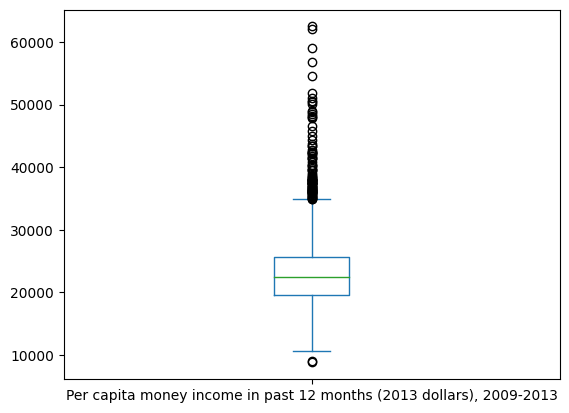

In [557]:
X.plot(kind='box')

# age

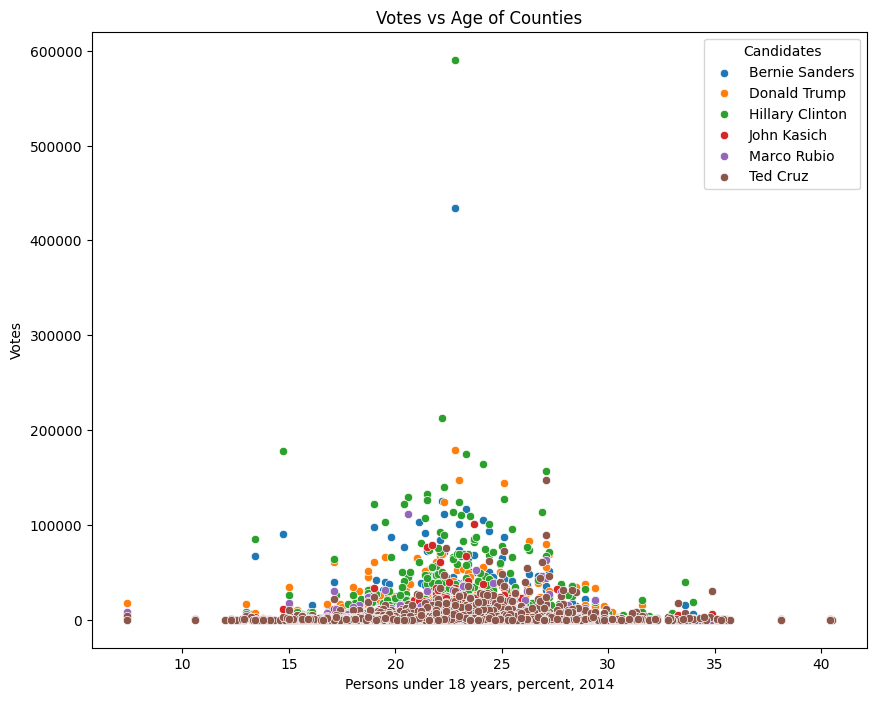

In [579]:
df = cdf(afdf)
import seaborn as sns
import matplotlib.pyplot as plt

# Select the relevant columns from the data
candidate_cols = ['Bernie Sanders', 'Donald Trump', 'Hillary Clinton', 'John Kasich', 'Marco Rubio', 'Ted Cruz']
age_col = 'Persons under 18 years, percent, 2014'
data = df[candidate_cols + [age_col]]

# Plotting the relationship between votes and age
plt.figure(figsize=(10, 8))
for candidate in candidate_cols:
    sns.scatterplot(data=data, x=age_col, y=candidate, label=candidate)

plt.xlabel('Persons under 18 years, percent, 2014')
plt.ylabel('Votes')
plt.title('Votes vs Age of Counties')
plt.legend(title='Candidates')
plt.show()


# race

In [758]:
df = cdf(rfdf)
df

state_abbreviation_x    county_x  Bernie Sanders  Donald Trump   
fips                                                                     
1001.0                    AL     Autauga           544.0        5387.0  \
1003.0                    AL     Baldwin          2694.0       23618.0   
1005.0                    AL     Barbour           222.0        1710.0   
1007.0                    AL        Bibb           246.0        1959.0   
1009.0                    AL      Blount           395.0        7390.0   
...                      ...         ...             ...           ...   
56037.0                   WY  Sweetwater            12.0           0.0   
56039.0                   WY       Teton             9.0           0.0   
56041.0                   WY       Uinta             5.0           0.0   
56043.0                   WY    Washakie             1.0           0.0   
56045.0                   WY      Weston             1.0           0.0   

         Hillary Clinton  John Kasich  Marco Rubio  Ted Cruz   
fips                                                           
1001.0            2387.0        421.0       1785.0    2482.0  \
1003.0            5290.0       2987.0       9703.0    8571.0   
1005.0            2567.0        123.0        498.0     609.0   
1007.0             942.0         84.0        444.0    1011.0   
1009.0             564.0        337.0       1843.0    3698.0   
...                  ...          ...          ...       ...   
56037.0             10.0          0.0          0.0       0.0   
56039.0              6.0          0.0          0.0       0.0   
56041.0              4.0          0.0          0.0       0.0   
56043.0              2.0          0.0          0.0       0.0   
56045.0              1.0          0.0          0.0       0.0   

         White alone, percent, 2014   
fips                                  
1001.0                         77.9  \
1003.0                         87.1   
1005.0                         50.2   
1007.0                         76.3   
1009.0                         96.0   
...                             ...   
56037.0                        94.3   
56039.0                        94.9   
56041.0                        95.4   
56043.0                        94.8   
56045.0                        95.0   

         Black or African American alone, percent, 2014   
fips                                                      
1001.0                                             18.7  \
1003.0                                              9.6   
1005.0                                             47.6   
1007.0                                             22.1   
1009.0                                              1.8   
...                                                 ...   
56037.0                                             1.5   
56039.0                                             1.2   
56041.0                                             0.9   
56043.0                                             0.8   
56045.0                                             0.7   

         American Indian and Alaska Native alone, percent, 2014   
fips                                                              
1001.0                                                 0.5       \
1003.0                                                 0.7        
1005.0                                                 0.6        
1007.0                                                 0.4        
1009.0                                                 0.6        
...                                                    ...        
56037.0                                                1.3        
56039.0                                                1.0        
56041.0                                                1.2        
56043.0                                                1.7        
56045.0                                                1.7        

         Asian alone, percent, 2014   
fips                     

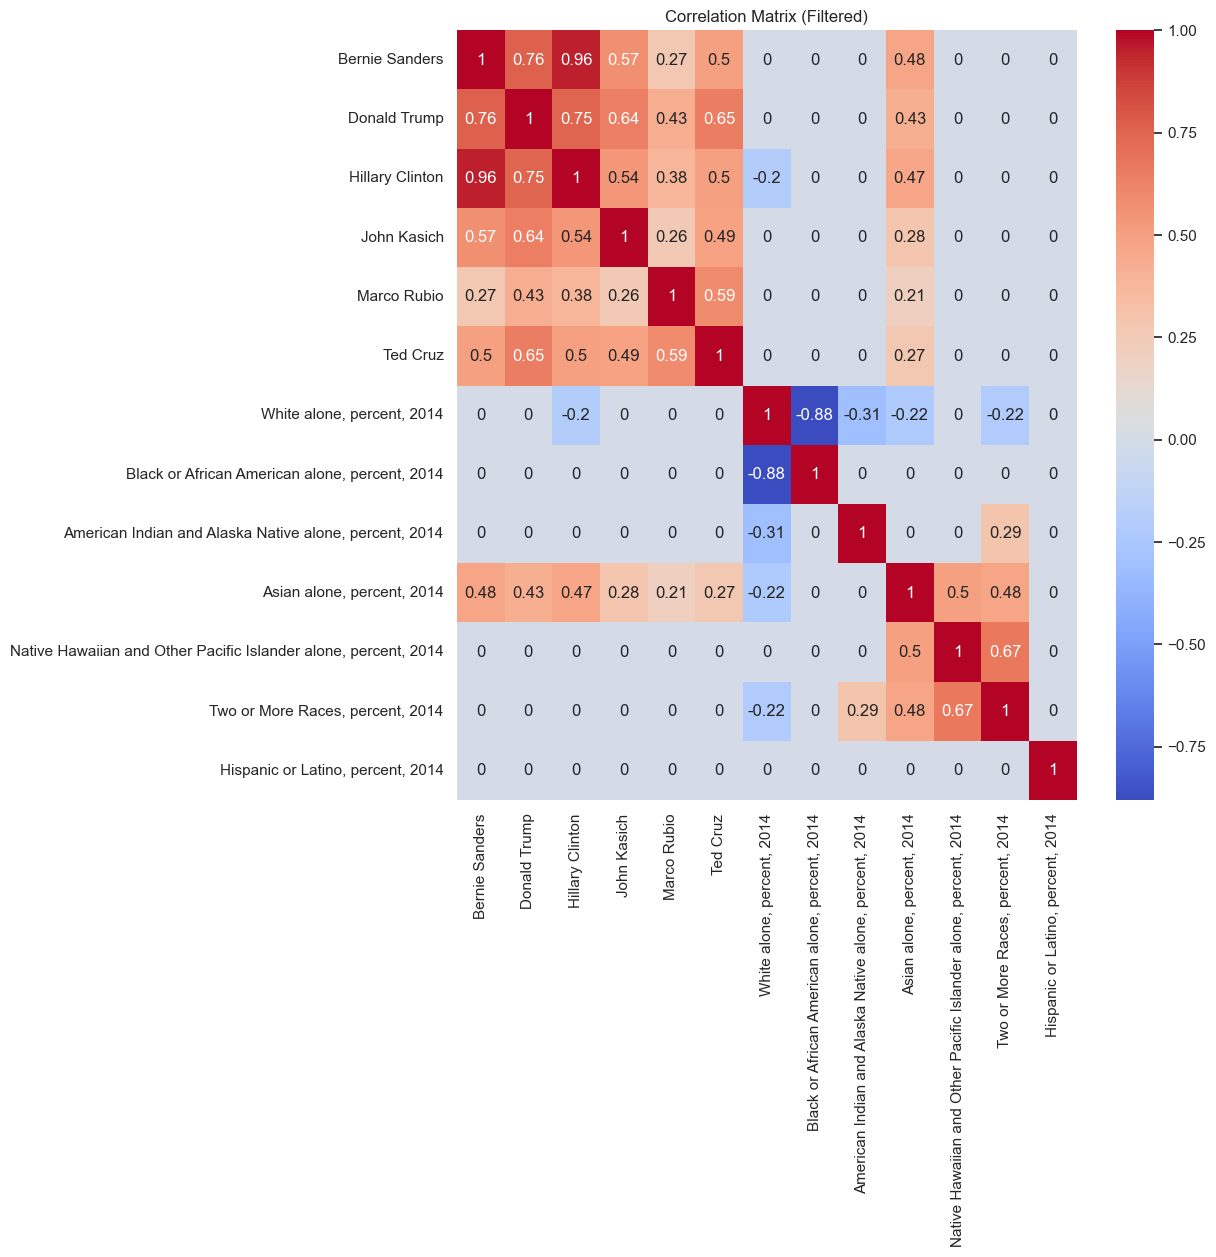

In [760]:
import seaborn as sns
import matplotlib.pyplot as plt

# Get the correlation matrix
correlation_matrix = df.iloc[:, 2:15].corr()

# Filter the correlation matrix to show only values above 0.4 and below -0.4
filtered_matrix = correlation_matrix.where((correlation_matrix > 0.2) | (correlation_matrix < -0.2), 0)

# Plot the filtered correlation matrix
sns.heatmap(filtered_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix (Filtered)")
plt.show()

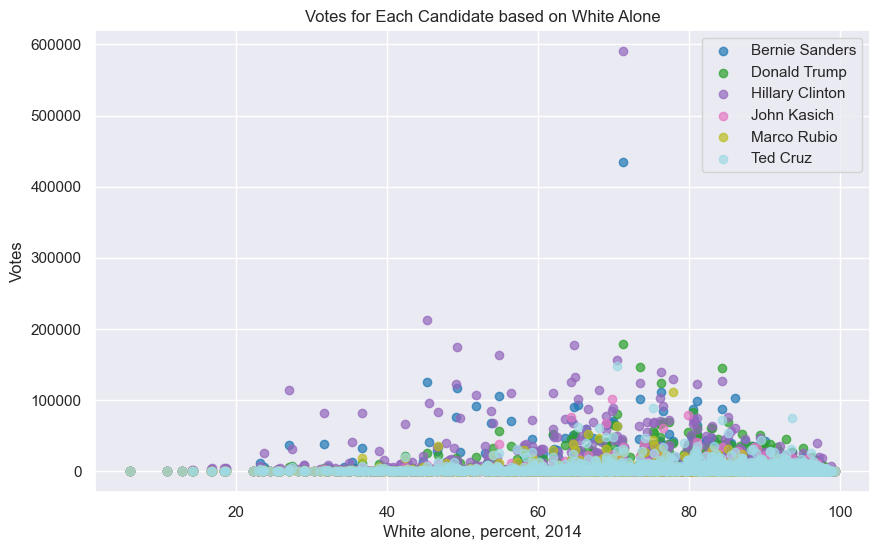

In [761]:
import matplotlib.pyplot as plt
import numpy as np

# Define the candidate columns
candidate_columns = ['Bernie Sanders', 'Donald Trump', 'Hillary Clinton', 'John Kasich', 'Marco Rubio', 'Ted Cruz']

# Sort the DataFrame by the "White alone, percent, 2014" column
sorted_df = df.sort_values("White alone, percent, 2014", ascending=False)

# Create a color map with more colors
colors = plt.cm.tab20(np.linspace(0, 1, len(candidate_columns)))

# Plot the votes for each candidate
plt.figure(figsize=(10, 6))
for i, candidate in enumerate(candidate_columns):
    plt.scatter(sorted_df["White alone, percent, 2014"], sorted_df[candidate], color=colors[i], alpha=0.7, label=candidate)

plt.xlabel("White alone, percent, 2014")
plt.ylabel("Votes")
plt.title("Votes for Each Candidate based on White Alone")
plt.legend()
plt.show()


In [706]:
cf.iloc[0,11:19]

White alone, percent, 2014                                         77.4
Black or African American alone, percent, 2014                     13.2
American Indian and Alaska Native alone, percent, 2014              1.2
Asian alone, percent, 2014                                          5.4
Native Hawaiian and Other Pacific Islander alone, percent, 2014     0.2
Two or More Races, percent, 2014                                    2.5
Hispanic or Latino, percent, 2014                                  17.4
White alone, not Hispanic or Latino, percent, 2014                 62.1
Name: 0, dtype: object

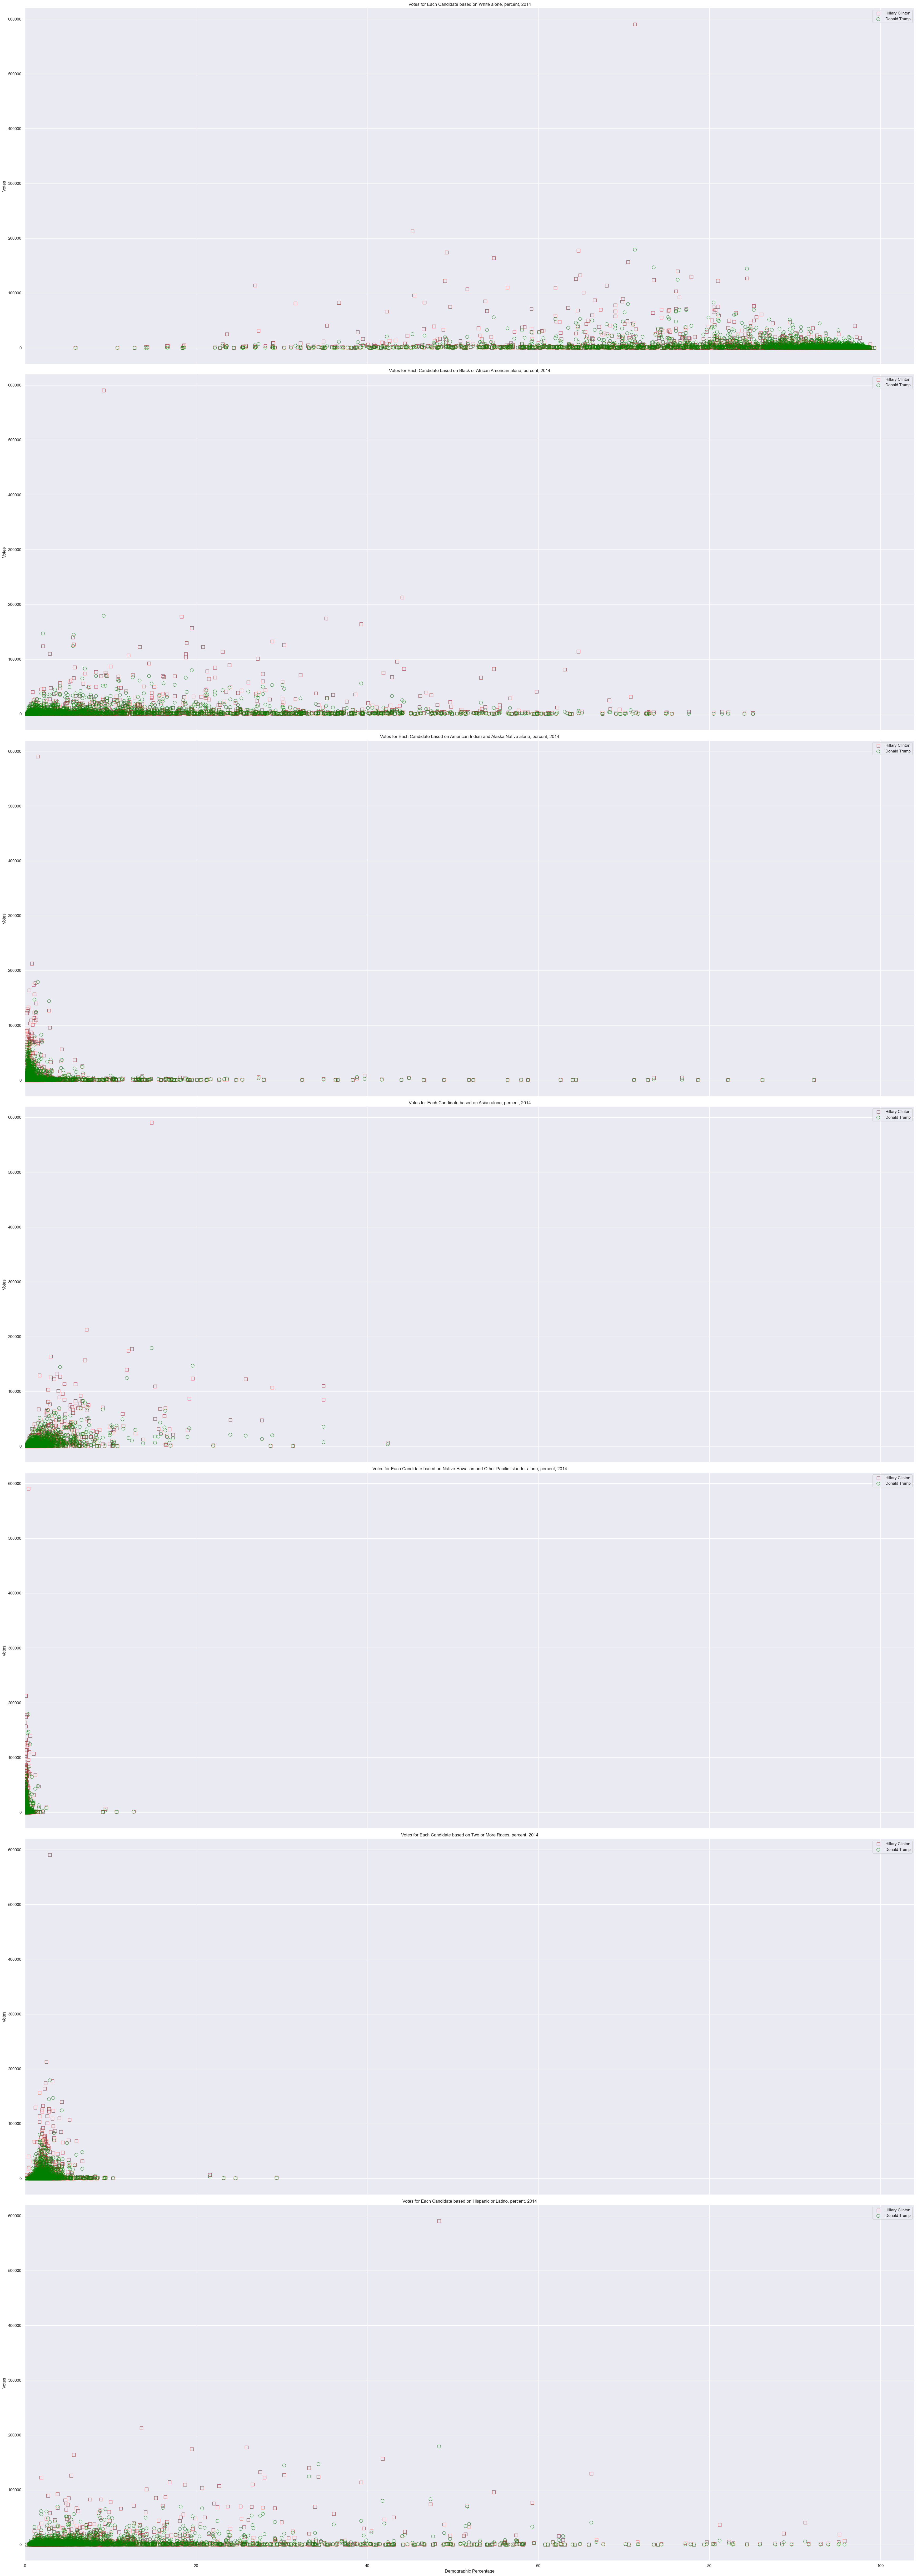

In [822]:
import matplotlib.pyplot as plt
import numpy as np

candidate_columns = ['Bernie Sanders', 'Donald Trump', 'Hillary Clinton', 'John Kasich', 'Marco Rubio', 'Ted Cruz']

# Calculate the total votes
df['Total Votes'] = df[candidate_columns].sum(axis=1)

# Calculate the percentage votes for each candidate
df_percentages = df[candidate_columns].div(df['Total Votes'], axis=0) * 100

# Add the percentage votes to the DataFrame
df = pd.concat([df, df_percentages.add_suffix(' (%)')], axis=1)

# Define the candidate columns
candidate_columns = ['Hillary Clinton', 'Donald Trump']

# Calculate the total votes
df['Total Votes'] = df[candidate_columns].sum(axis=1)

# Create a list of race columns to iterate over
race_columns = ['White alone, percent, 2014', 'Black or African American alone, percent, 2014',
                'American Indian and Alaska Native alone, percent, 2014', 'Asian alone, percent, 2014',
                'Native Hawaiian and Other Pacific Islander alone, percent, 2014',
                'Two or More Races, percent, 2014', 'Hispanic or Latino, percent, 2014']

# Calculate the number of rows and columns for subplots
num_rows = len(race_columns)
num_cols = 1

# Create subplots for each race
fig, axs = plt.subplots(num_rows, num_cols, figsize=(35, 14 * num_rows), sharex=True)

# Adjust the vertical spacing between subplots
plt.subplots_adjust(hspace=0.5)

# Iterate over the race columns and create a subplot for each race
for i, race in enumerate(race_columns):
    # Sort the DataFrame by the current race column
    sorted_df = df.sort_values(race, ascending=False)

    # Define the colors for each candidate
    colors = ['brown', 'green']

    # Define the markers for each candidate
    markers = ['s', 'o']

    # Define the marker size for each candidate
    marker_size = 80

    # Plot the percentages for each candidate on the current subplot
    for j, candidate in enumerate(candidate_columns):
        # Plot the marker with no middle (only periphery)
        axs[i].scatter(sorted_df[race], sorted_df[f'{candidate}'], marker=markers[j], color=colors[j],
                       s=marker_size, facecolors='none', edgecolors=colors[j], alpha=0.7, label=candidate)

    axs[i].set_ylabel("Votes")
    axs[i].set_title(f"Votes for Each Candidate based on {race}")
    axs[i].legend()
    axs[i].set_xlim(0 )

# Set the x-axis label for the last subplot
axs[-1].set_xlabel("Demographic Percentage")

plt.tight_layout()
plt.show()


C:\Users\metac\AppData\Local\Temp\ipykernel_11772\67809213.py:22: RuntimeWarning: divide by zero encountered in divide
  percentages = (vote_counts / total_votes) * 100
C:\Users\metac\AppData\Local\Temp\ipykernel_11772\67809213.py:22: RuntimeWarning: invalid value encountered in divide
  percentages = (vote_counts / total_votes) * 100


IndexError: list index out of range

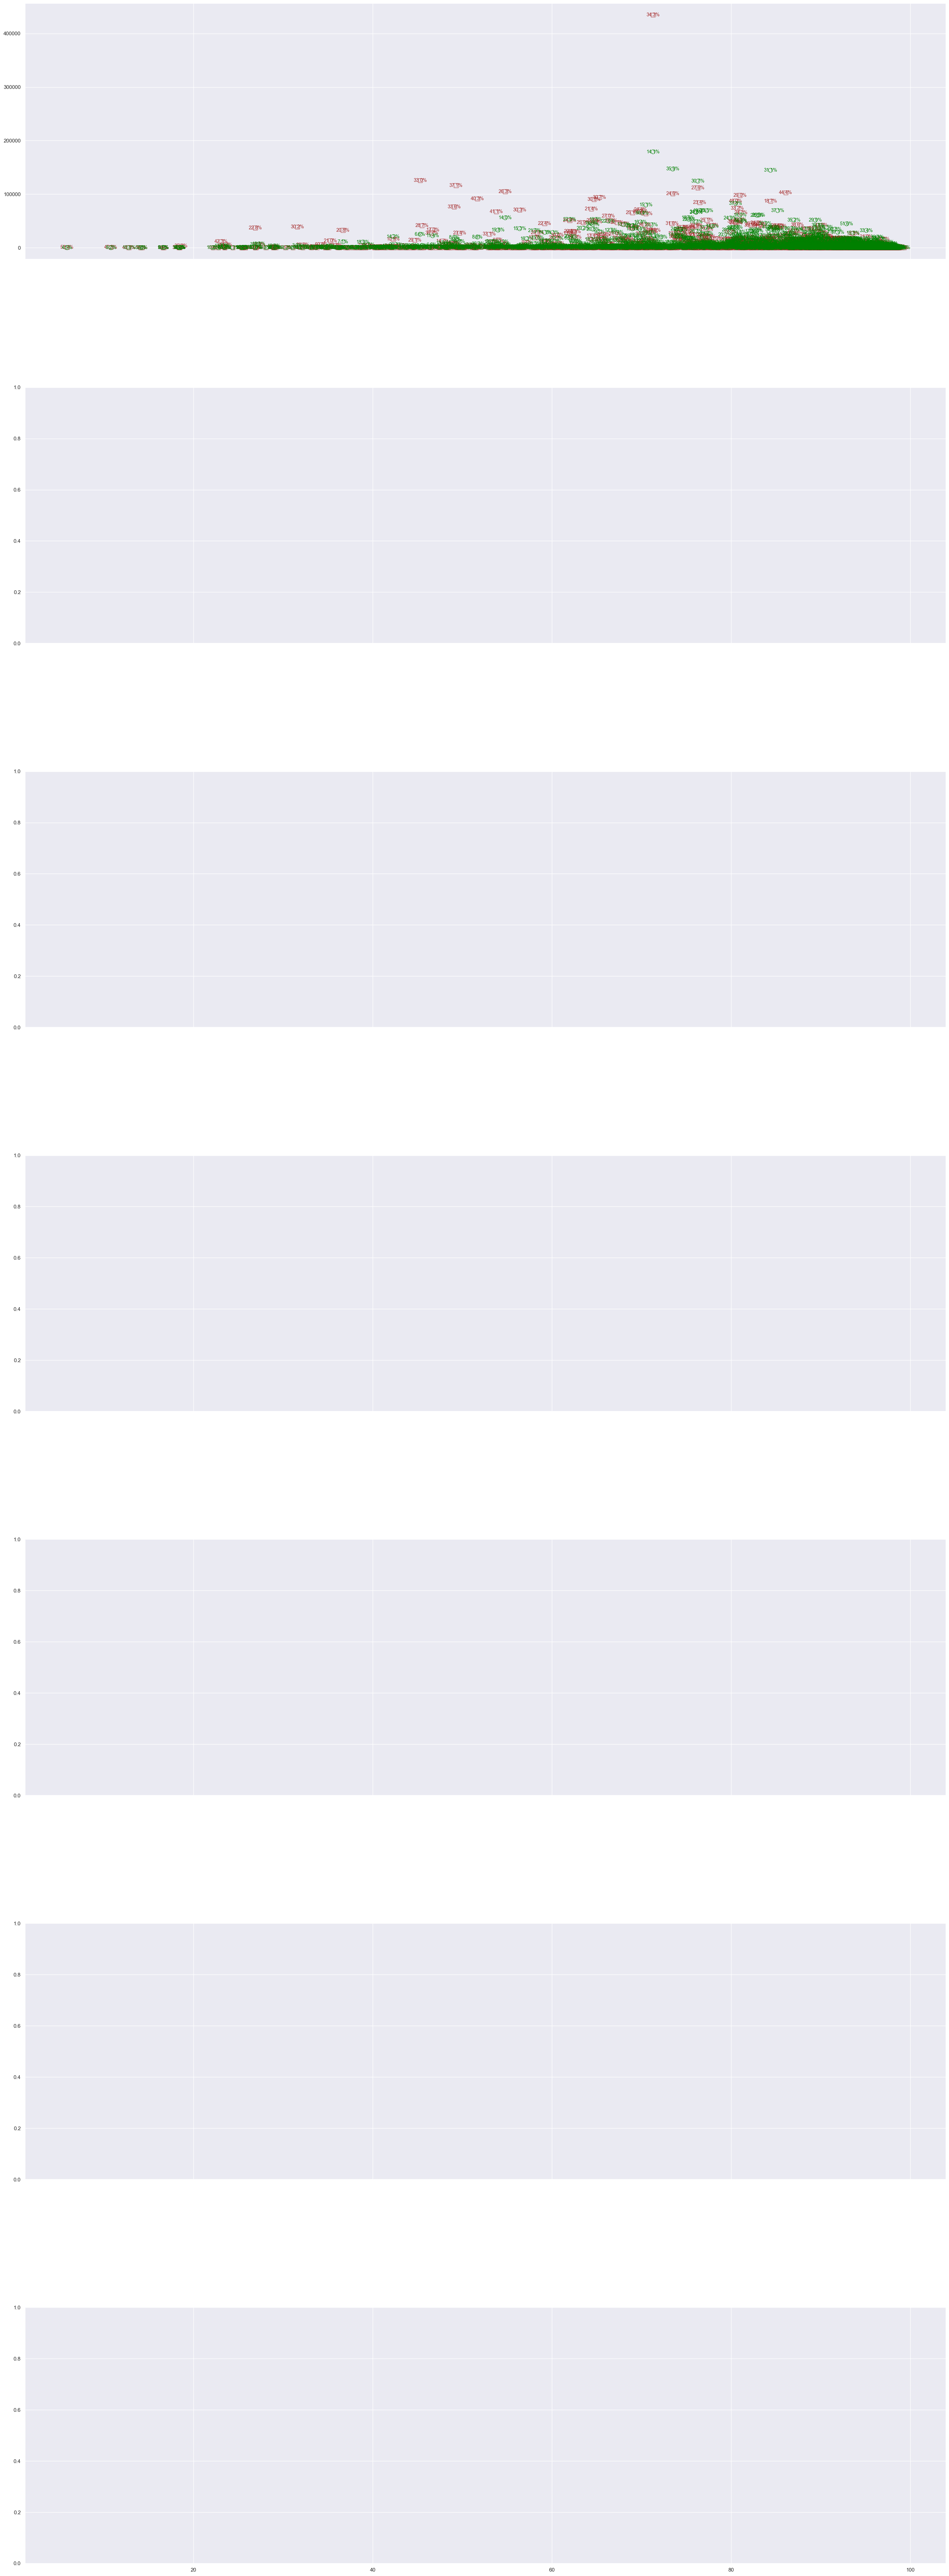

In [825]:
import matplotlib.pyplot as plt
import numpy as np

# Create a dictionary to store sorted DataFrames for each race
sorted_dfs = {}

# Create a list of race columns to iterate over
race_columns = ['White alone, percent, 2014', 'Black or African American alone, percent, 2014',
                'American Indian and Alaska Native alone, percent, 2014', 'Asian alone, percent, 2014',
                'Native Hawaiian and Other Pacific Islander alone, percent, 2014',
                'Two or More Races, percent, 2014', 'Hispanic or Latino, percent, 2014']

# Iterate over the race columns and create sorted DataFrames for each race
for race in race_columns:
    sorted_dfs[race] = df.sort_values(race, ascending=False)

# Define the candidate columns
candidate_columns =  ['Bernie Sanders', 'Donald Trump', 'Hillary Clinton', 'John Kasich', 'Marco Rubio', 'Ted Cruz']
# Calculate the percentages for each candidate using NumPy
vote_counts = df[candidate_columns].values
total_votes = df['Total Votes'].values[:, np.newaxis]
percentages = (vote_counts / total_votes) * 100

# Create a new DataFrame with the percentage values
df_percentages = pd.DataFrame(percentages, columns=[f'{candidate} (%)' for candidate in candidate_columns])

# Calculate the number of rows and columns for subplots
num_rows = len(race_columns)
num_cols = 1

# Create subplots for each race
fig, axs = plt.subplots(num_rows, num_cols, figsize=(35, 14 * num_rows), sharex=True)

# Adjust the vertical spacing between subplots
plt.subplots_adjust(hspace=0.5)

# Iterate over the race columns and create a subplot for each race
for i, race in enumerate(race_columns):
    # Retrieve the sorted DataFrame for the current race
    sorted_df = sorted_dfs[race]

    # Define the colors for each candidate
    colors = ['brown', 'green']

    # Define the markers for each candidate
    markers = ['s', 'o']

    # Define the marker size for each candidate
    marker_size = 80

    # Plot the percentages for each candidate on the current subplot
    for j, candidate in enumerate(candidate_columns):
        # Plot the marker with no middle (only periphery)
        axs[i].scatter(sorted_df[race], sorted_df[f'{candidate}'], marker=markers[j], color=colors[j],
                       s=marker_size, facecolors='none', edgecolors=colors[j], alpha=0.7, label=candidate)
        
        # Plot the percentage values as text labels
        for x, y, p in zip(sorted_df[race], sorted_df[f'{candidate}'], sorted_df[f'{candidate} (%)']):
            axs[i].text(x, y, f'{p:.1f}%', ha='center', va='center', fontsize=10, color=colors[j])

    axs[i].set_ylabel("Votes")
    axs[i].set_title(f"Votes for Each Candidate based on {race}")
    axs[i].legend()

# Set the x-axis label for the last subplot
axs[-1].set_xlabel("Demographic Percentage")

plt.tight_layout()
plt.show()


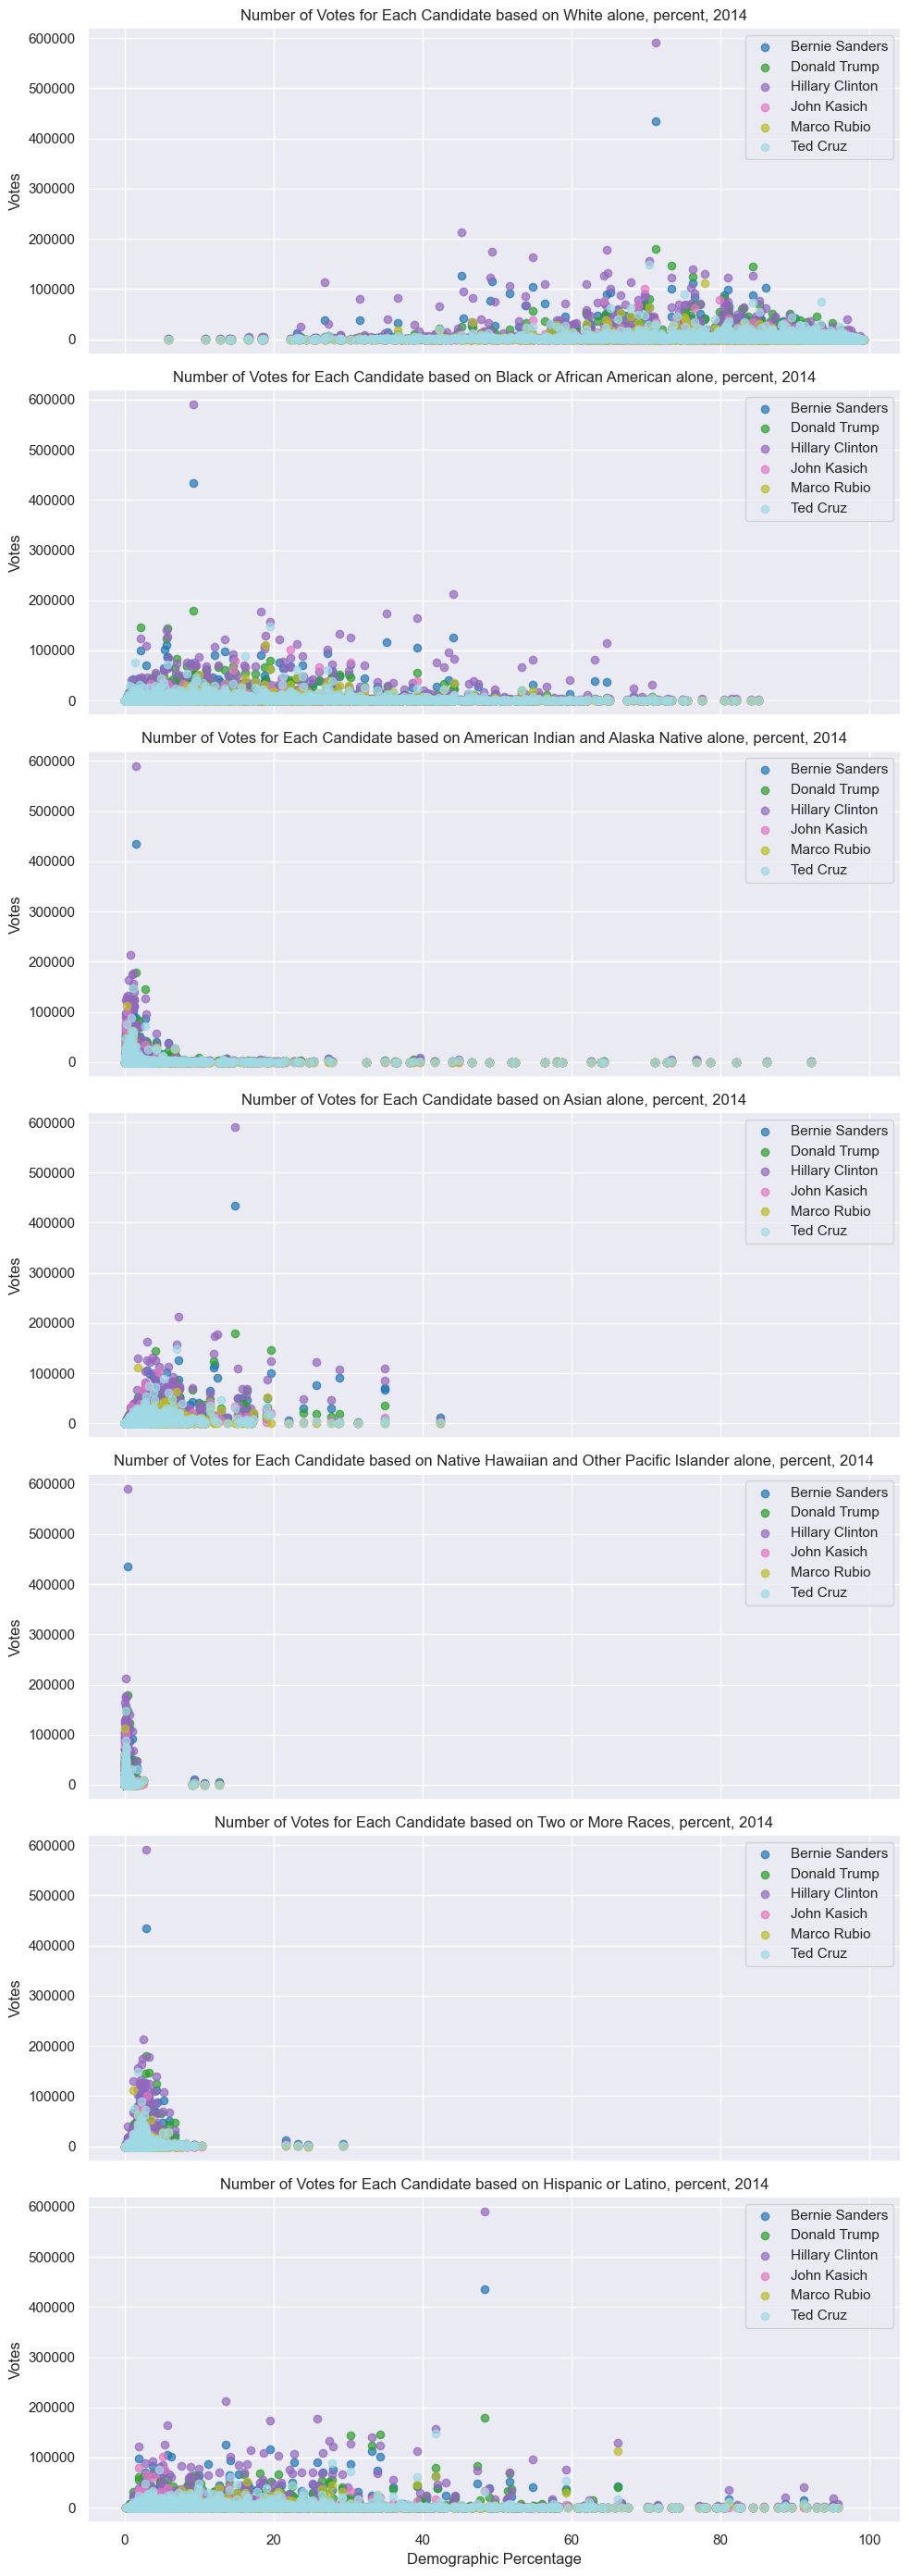

In [767]:
import matplotlib.pyplot as plt
import numpy as np

# Define the candidate columns
candidate_columns = ['Bernie Sanders', 'Donald Trump', 'Hillary Clinton', 'John Kasich', 'Marco Rubio', 'Ted Cruz']

# Create a list of race columns to iterate over
race_columns = ['White alone, percent, 2014', 'Black or African American alone, percent, 2014', 'American Indian and Alaska Native alone, percent, 2014', 'Asian alone, percent, 2014', 'Native Hawaiian and Other Pacific Islander alone, percent, 2014', 'Two or More Races, percent, 2014', 'Hispanic or Latino, percent, 2014']

# Calculate the number of rows and columns for subplots
num_rows = len(race_columns)
num_cols = 1

# Create subplots for each race
fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 4*num_rows), sharex=True)

# Adjust the vertical spacing between subplots
plt.subplots_adjust(hspace=0.5)

# Iterate over the race columns and create a subplot for each race
for i, race in enumerate(race_columns):
    # Sort the DataFrame by the current race column
    sorted_df = df.sort_values(race, ascending=False)
    
    # Create a color map with more colors
    colors = plt.cm.tab20(np.linspace(0, 1, len(candidate_columns)))

    # Plot the actual votes for each candidate on the current subplot
    for j, candidate in enumerate(candidate_columns):
        axs[i].scatter(sorted_df[race], sorted_df[candidate], color=colors[j], alpha=0.7, label=candidate)
    
    axs[i].set_ylabel("Votes")
    axs[i].set_title(f"Number of Votes for Each Candidate based on {race}")
    axs[i].legend()

# Set the x-axis label for the last subplot
axs[-1].set_xlabel("Demographic Percentage")

plt.tight_layout()
plt.show()


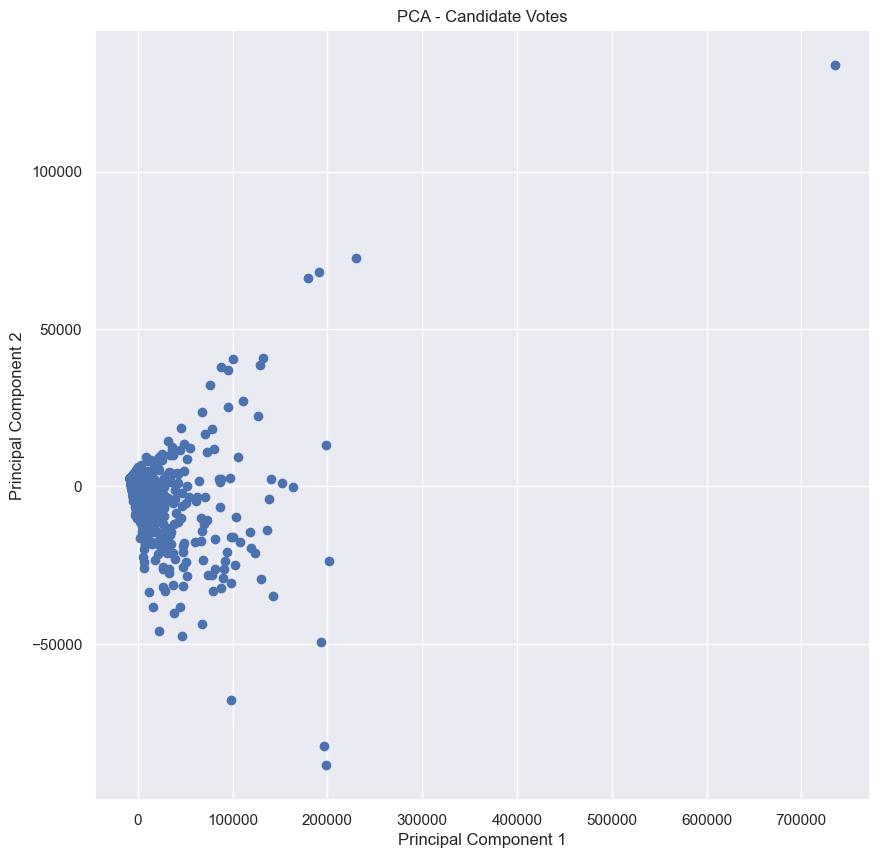

In [718]:
from sklearn.decomposition import PCA

# Select the candidate columns for analysis
candidate_columns = ['Bernie Sanders', 'Donald Trump', 'Hillary Clinton', 'John Kasich', 'Marco Rubio', 'Ted Cruz']

# Subset the data for candidate columns
data = df[candidate_columns]

# Apply PCA
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(data)

# Create a scatter plot of the reduced data
plt.scatter(reduced_data[:, 0], reduced_data[:, 1])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA - Candidate Votes')
plt.show()
